<a href="https://colab.research.google.com/github/D3sert650/SEM_Assignment_1/blob/main/Final_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports, Functions and Preprocessing**

In [ ]:
%%capture
!pip install cellxgene-census
!pip install scanpy
!pip install pandas_profiling
!pip install pydantic-settings
!pip install ydata-profiling
!pip install jupyter-contrib-nbextensions
!pip install scikit-learn
!pip install igraph
!pip install scvi-tools
!pip install scikit-misc
!pip install leidenalg
!pip install fastcluster
!pip install gseapy
!pip install pybiomart
!pip install lazypredict
!pip install py-scProportionTest
!pip install mygene
!pip install hyperopt

In [ ]:
%%capture
# Standard library imports
import os
import sys
import time
import warnings
from io import StringIO
import gzip
import ftplib
import urllib

# Data manipulation and analysis
import pandas as pd
import numpy as np
import scipy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib import rcParams


# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from lazypredict.Supervised import LazyClassifier
from sklearn import preprocessing
import sklearn

# Bioinformatics and omics analysis
import scanpy
import scanpy as sc
import cellxgene_census
import tiledbsoma
import gseapy
import mygene
import pybiomart
import scProportionTest as pt

# Profiling and reports
from ydata_profiling import ProfileReport

# Web scraping and API requests
import requests

import xgboost as xgb
from sklearn.metrics import f1_score, recall_score, confusion_matrix,roc_auc_score
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss

In [ ]:
# Download and load Dataset - URL https://cellxgene.cziscience.com/collections/b953c942-f5d8-434f-9da7-e726ba7c1481
try:
  cellxgene_census.download_source_h5ad("9813a1d4-d107-459e-9b2e-7687be935f69", to_path="inhibitory.h5ad")
except:
  print("Already downloaded")
adata = sc.read_h5ad("inhibitory.h5ad")
adata = adata[adata.obs['SORT'] != 'AT8']

# Load genes
urllib.request.urlretrieve("https://raw.githubusercontent.com/D3sert650/SEM_Assignment_1/refs/heads/main/data/differential_expression_AD_Normal.csv","differential_expression_AD_Normal.csv")
genes = pd.read_csv("differential_expression_AD_Normal.csv",comment="#")
genes.head()

#Load annotations for blood sample = URL https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL6947
urllib.request.urlretrieve("https://raw.githubusercontent.com/D3sert650/SEM_Assignment_1/refs/heads/main/data/GPL6947-13512.txt","GPL6947-13512.txt")


# Download Blood Sample dataset - URL https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL6947
# Source: Francisco
print("Loading blood sample AD...")
blood_sample_file_path = "/content/GPL6947_HumanHT-12_V3_0_R1_11283641_A.bgx.gz"
ftp_url = "ftp.ncbi.nlm.nih.gov"
ftp_directory = "/geo/series/GSE63nnn/GSE63060/matrix/"
file_name = "GSE63060_series_matrix.txt.gz"

if not os.path.isfile(blood_sample_file_path):
    with ftplib.FTP(ftp_url) as ftp:
        ftp.login()
        ftp.cwd(ftp_directory)

        with open(blood_sample_file_path, "wb") as file:
            ftp.retrbinary(f"RETR {file_name}", file.write)

print("Loading Gene mapping data...")
gene_mapping_file_path = "GPL6947_HumanHT-12_V3_0_R1_11283641_A.bgx.gz"
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GPL6947&format=file&file=GPL6947%5FHumanHT%2D12%5FV3%5F0%5FR1%5F11283641%5FA%2Ebgx%2Egz"

if not os.path.isfile(gene_mapping_file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(gene_mapping_file_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

print("Everything loaded")

#Load Blood Sample dataset
# Source: Francisco
with gzip.open(blood_sample_file_path, 'rt', encoding='latin1') as file:
    lines = file.readlines()

metadata_lines = []
data_lines = []
for line in lines:
    if line.startswith("!"):
        metadata_lines.append(line.strip())
    else:
        data_lines.append(line.strip())

metadata_df = pd.DataFrame([line.split("\t") for line in metadata_lines if "characteristics" in line])

status_row = metadata_df.iloc[0, 1:]
age_row = metadata_df.iloc[2, 1:]
gender_row = metadata_df.iloc[3, 1:]
status_data = status_row.str.replace('"status: ', '').str.replace('"', '')
age_data = age_row.str.replace('"age: ', '').str.replace('"', '').astype(int)
gender_data = gender_row.str.replace('"gender: ', '').str.replace('"', '')

subject_info_df = pd.DataFrame({
    'Status': status_data.values,
    'Age': age_data.values,
    'Gender': gender_data.values
})
subject_info_df.index = age_data.index

data_str = "\n".join(data_lines)
data_df = pd.read_csv(StringIO(data_str), sep='\t')

data_transposed = data_df.set_index('ID_REF').T
data_transposed.index.name = 'Sample_ID'

subject_info_df.index = data_transposed.index

dataset = pd.concat([subject_info_df, data_transposed], axis=1)
dataset["Status"] = dataset["Status"]

metadata = metadata_df.transpose()
metadata.columns = metadata.iloc[0]
metadata = metadata.iloc[1:]
metadata.index.name = "Sample"
metadata.columns = ["Status","Ethnicity","Age","Gender","Control","Tissue"]
metadata = metadata.applymap(lambda x: x.split(": ",1)[-1].replace('"',''))
metadata.Age = metadata.Age.astype(int)


annotations = pd.read_csv(
    "GPL6947-13512.txt",
    delimiter="\t",
    comment="!",
    skiprows=30
)
genes = annotations.ILMN_Gene.unique()



Already downloaded
Loading blood sample AD...
Loading Gene mapping data...
Everything loaded


In [ ]:
# Gene mapping
gene_alias = dict(map(lambda i,j : (i,j), adata.var.index, adata.var['feature_name']))
gene_aliases = dict((v, k) for k, v in gene_alias.items())

In [ ]:
# Annotate Mito and Ribo Genes
adata.var['mt'] = adata.var.feature_name.str.startswith('MT-')
adata.var[adata.var['mt']]
ribo_genes = pd.read_table("http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt", skiprows=2, header = None)
adata.var['ribo'] = adata.var.feature_name.isin(ribo_genes[0].values)
adata.var[adata.var['ribo']]

feature_is_filtered feature_name feature_reference  \
ENSG00000137818                False        RPLP1    NCBITaxon:9606   
ENSG00000130255                False        RPL36    NCBITaxon:9606   
ENSG00000174748                False        RPL15    NCBITaxon:9606   
ENSG00000137876                False      RSL24D1    NCBITaxon:9606   
ENSG00000163584                False      RPL22L1    NCBITaxon:9606   
...                              ...          ...               ...   
ENSG00000188846                False        RPL14    NCBITaxon:9606   
ENSG00000142676                False        RPL11    NCBITaxon:9606   
ENSG00000172809                False        RPL38    NCBITaxon:9606   
ENSG00000185088                False       RPS27L    NCBITaxon:9606   
ENSG00000118181                False        RPS25    NCBITaxon:9606   

                feature_biotype feature_length     mt  ribo  
ENSG00000137818            gene           3252  False  True  
ENSG00000130255            gene           2271  False  True  
ENSG00000174748            gene           7141  False  True  
ENSG00000137876            gene           6600  False  True  
ENSG00000163584            gene           2051  False  True  
...                         ...            ...    ...   ...  
ENSG00000188846            gene           8626  False  True  
ENSG00000142676            gene           2659  False  True  
ENSG00000172809            gene           3829  False  True  
ENSG00000185088            gene           8825  False  True  
ENSG00000118181            gene           1477  False  True  

[87 rows x 7 columns]

In [ ]:
# Calculate qc metrics and filter data according to this Paper and tutorial: https://youtu.be/uvyG9yLuNSE?si=-WVHD7G-yNSiVe0C | https://www.nature.com/articles/s41586-021-03569-1
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt","ribo"],percent_top=None,log1p=False, inplace=True)
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.pct_counts_mt < 10]
adata = adata[adata.obs.pct_counts_ribo < 8]
adata = adata[adata.obs.n_genes_by_counts < upper_lim]


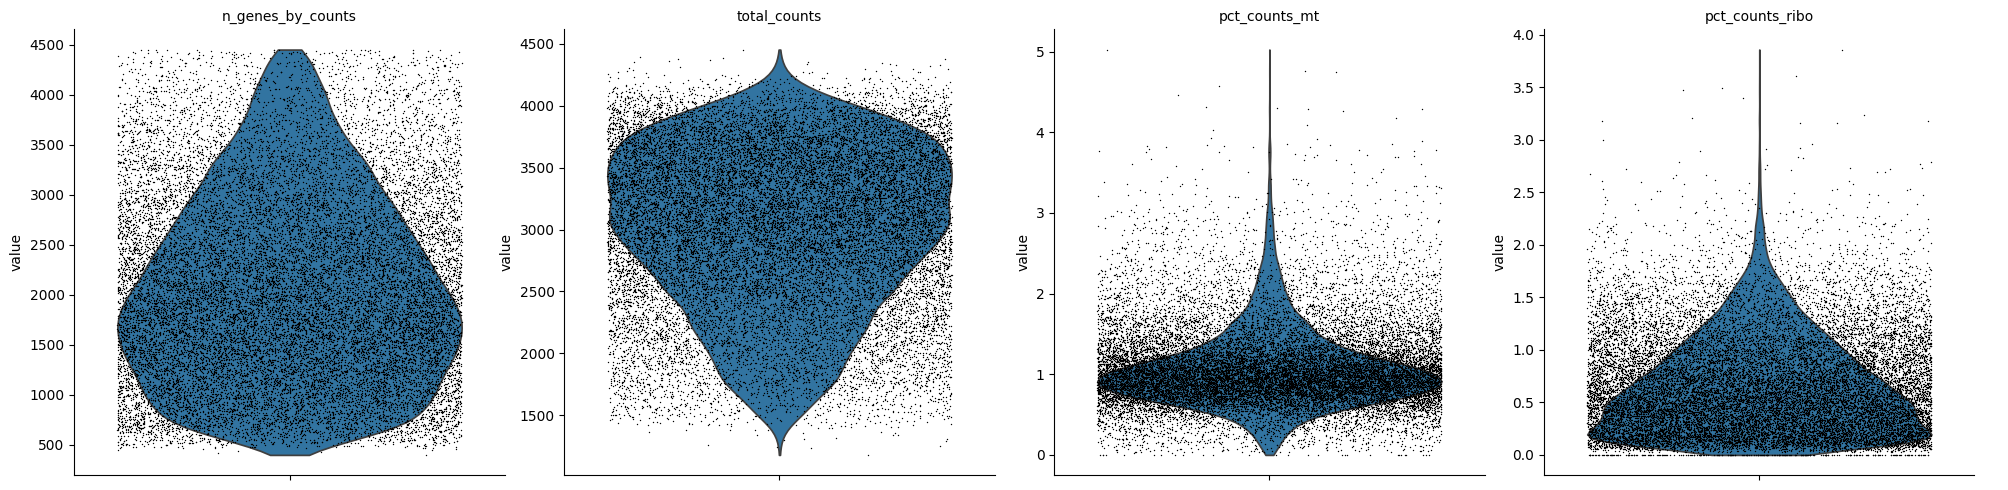

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

In [ ]:
# Quality Control
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5,subset=True)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2
)

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [ ]:
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

cll = ["XGBClassifier","LGBMClassifier","RandomForestClassifier","ExtraTreesClassifier","RidgeClassifierCV","RidgeClassifier","LinearDiscriminantAnalysis","PassiveAggressiveClassifier","Perceptron","SGDClassifier","LogisticRegression","NearestCentroid","ExtraTreeClassifier","GaussianNB","BernoulliNB","DummyClassifier","LabelSpreading","LabelPropagation"]

clf_list = [est for est in all_estimators() if (issubclass(est[1], ClassifierMixin) and (est[0] in cll))]

c_list = []
for clf in clf_list:
  c_list.append(clf[1])

#**Data Preview**

In [ ]:
# CellxGene - Single-soma transcriptomics of tangle-bearing neurons in Alzheimer’s disease
print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 21921 × 4477
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'SORT', 'Amyloid', 'Age', 'RIN', 'nCount_SCT', 'nFeature_SCT', 'nCount_Exon', 'nFeature_Exon', 'PMI', 'Braak', 'Sample.ID', 'Cell.Types', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'clusters'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 

nCount_RNA  nFeature_RNA  percent.mt  SORT Amyloid  \
C0001_AAACGGGCAGTACACT-1      927.00           694        1.83  MAP2      C3   
C0001_AAACGGGGTACCGTAT-1     1251.00           886        6.47  MAP2      C3   
C0001_AAACGGGTCCAGAGGA-1     2972.00          1695        0.20  MAP2      C3   
C0001_AAACGGGTCCTTCAAT-1     3619.00          1875        2.46  MAP2      C3   
C0001_AAAGATGGTCAACATC-1     3931.00          2247        2.47  MAP2      C3   

                         Age  RIN  nCount_SCT  nFeature_SCT  nCount_Exon  ...  \
C0001_AAACGGGCAGTACACT-1  73  5.7     2092.00           787       344.00  ...   
C0001_AAACGGGGTACCGTAT-1  73  5.7     2440.00           915       598.00  ...   
C0001_AAACGGGTCCAGAGGA-1  73  5.7     2949.00          1695       968.00  ...   
C0001_AAACGGGTCCTTCAAT-1  73  5.7     3269.00          1873      1442.00  ...   
C0001_AAAGATGGTCAACATC-1  73  5.7     3441.00          2246      1753.00  ...   

                                development_stage observation_joinid  \
C0001_AAACGGGCAGTACACT-1  73-year-old human stage         5$tsN89o-C   
C0001_AAACGGGGTACCGTAT-1  73-year-old human stage         i+HeMEM)4<   
C0001_AAACGGGTCCAGAGGA-1  73-year-old human stage         oi@)SZWo%-   
C0001_AAACGGGTCCTTCAAT-1  73-year-old human stage         V#;BPg@9;|   
C0001_AAAGATGGTCAACATC-1  73-year-old human stage         dk0gL6!4f@   

                         n_genes_by_counts total_counts total_counts_mt  \
C0001_AAACGGGCAGTACACT-1               690      1812.38           22.45   
C0001_AAACGGGGTACCGTAT-1               881      2086.60           40.76   
C0001_AAACGGGTCCAGAGGA-1              1681      2891.53            7.94   
C0001_AAACGGGTCCTTCAAT-1              1865      2964.29           30.17   
C0001_AAAGATGGTCAACATC-1              2240      3369.76           31.26   

                         pct_counts_mt total_counts_ribo pct_counts_ribo  \
C0001_AAACGGGCAGTACACT-1          1.24              4.93            0.27   
C0001_AAACGGGGTACCGTAT-1          1.95             11.62            0.56   
C0001_AAACGGGTCCAGAGGA-1          0.27             10.89            0.38   
C0001_AAACGGGTCCTTCAAT-1          1.02              7.95            0.27   
C0001_AAAGATGGTCAACATC-1          0.93             30.54            0.91   

                         n_genes clusters  
C0001_AAACGGGCAGTACACT-1     690        0  
C0001_AAACGGGGTACCGTAT-1     881        1  
C0001_AAACGGGTCCAGAGGA-1    1681        2  
C0001_AAACGGGTCCTTCAAT-1    1865        1  
C0001_AAAGATGGTCAACATC-1    2240        1  

[5 rows x 44 columns]

In [ ]:
# Illumina HumanHT-12 V3.0 expression beadchip - Blood sample dataset metadata
metadata_df.head()

0                                       1    \
0  !Sample_characteristics_ch1                           "status: MCI"   
1  !Sample_characteristics_ch1           "ethnicity: Western European"   
2  !Sample_characteristics_ch1                               "age: 65"   
3  !Sample_characteristics_ch1                        "gender: Female"   
4  !Sample_characteristics_ch1  "included in case -control study: yes"   

                                      2    \
0                           "status: MCI"   
1            "ethnicity: Other Caucasian"   
2                               "age: 66"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      3    \
0                           "status: MCI"   
1           "ethnicity: Western European"   
2                               "age: 67"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      4    \
0                           "status: MCI"   
1                    "ethnicity: Unknown"   
2                               "age: 67"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      5    \
0                           "status: MCI"   
1           "ethnicity: Western European"   
2                               "age: 67"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      6    \
0                           "status: MCI"   
1           "ethnicity: Western European"   
2                               "age: 68"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      7    \
0                           "status: MCI"   
1           "ethnicity: Western European"   
2                               "age: 69"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      8    \
0                           "status: MCI"   
1           "ethnicity: Western European"   
2                               "age: 69"   
3                        "gender: Female"   
4  "included in case -control study: yes"   

                                      9    ...  \
0                           "status: MCI"  ...   
1            "ethnicity: Other Caucasian"  ...   
2                               "age: 69"  ...   
3                        "gender: Female"  ...   
4  "included in case -control study: yes"  ...   

                                     320  \
0                          "status: MCI"   
1          "ethnicity: Western European"   
2                              "age: 82"   
3                       "gender: Female"   
4  "included in case -control study: no"   

                                     321  \
0                          "status: MCI"   
1          "ethnicity: Western European"   
2                              "age: 79"   
3                       "gender: Female"   
4  "included in case -control study: no"   

                                     322  \
0                          "status: MCI"   
1          "ethnicity: Western European"   
2                              "age: 76"   
3                       "gender: Female"   
4  "included in case -control study: no"   

                                     323  \
0                          "status: MCI"   
1          "ethnicity: Western European"   
2                              "age: 79"   
3                         "gender: Male"   
4  "included in case -control study: no"   

                                     324  \
0                          "status: MCI"   
1          "ethnicity: Western European"   
2                              "age: 79"   
3                         "gender: Male"   
4  "included in case -control study: no"   

                                     325  \
0              

In [ ]:
# Illumina HumanHT-12 V3.0 expression beadchip - Blood sample dataset observations
dataset.head()

Status  Age  Gender  ILMN_1343291  ILMN_1343295  ILMN_1651209  \
Sample_ID                                                                  
GSM1539080    MCI   65  Female         14.61         11.94          7.52   
GSM1539081    MCI   66  Female         14.43         11.93          7.55   
GSM1539082    MCI   67  Female         14.62         11.78          7.65   
GSM1539083    MCI   67  Female         14.44         12.42          7.75   
GSM1539084    MCI   67  Female         14.13         11.73          7.52   

            ILMN_1651221  ILMN_1651228  ILMN_1651229  ILMN_1651232  ...  \
Sample_ID                                                           ...   
GSM1539080          7.42         11.51          7.87          7.52  ...   
GSM1539081          7.40         10.51          8.22          7.51  ...   
GSM1539082          7.38         12.06          8.16          7.41  ...   
GSM1539083          7.44         10.65          7.97          7.67  ...   
GSM1539084          7.43         11.96          8.08          7.42  ...   

            ILMN_2415722  ILMN_2415748  ILMN_2415776  ILMN_2415786  \
Sample_ID                                                            
GSM1539080          8.00          8.85          7.64          9.15   
GSM1539081          8.07          9.18          7.62          9.61   
GSM1539082          8.01          8.71          7.62          9.72   
GSM1539083          7.57          8.68          7.82         10.12   
GSM1539084          7.52          8.77          7.48          9.23   

            ILMN_2415826  ILMN_2415898  ILMN_2415911  ILMN_2415926  \
Sample_ID                                                            
GSM1539080          7.47          8.12          7.65          7.90   
GSM1539081          7.51          7.83          7.66          8.00   
GSM1539082          7.47          8.12          7.75          8.01   
GSM1539083          7.49          7.86          7.87          8.26   
GSM1539084          7.42          7.85          7.70          7.98   

            ILMN_2415949  ILMN_2415979  
Sample_ID                               
GSM1539080          8.13          9.72  
GSM1539081          8.13         10.15  
GSM1539082          8.16         10.73  
GSM1539083          8.18          9.93  
GSM1539084          8.08         10.26  

[5 rows x 38326 columns]

In [ ]:
# Illumina HumanHT-12 V3.0 expression beadchip - Blood sample dataset annotations
annotations.head()

ID                nuID       Species   Source   Search_Key  \
0  ILMN_1725881  rp13_p1x6D80lNLk3c  Homo sapiens   RefSeq   ILMN_44919   
1  ILMN_1910180  NEX0oqCV8.er4HVfU4  Homo sapiens  Unigene  ILMN_127219   
2  ILMN_1804174  KyqQynMZxJcruyylEU  Homo sapiens   RefSeq  ILMN_139282   
3  ILMN_1796063  xXl7eXuF7sbPEp.KFI  Homo sapiens   RefSeq    ILMN_5006   
4  ILMN_1811966  9ckqJrioiaej9_ajeQ  Homo sapiens   RefSeq   ILMN_38756   

    Transcript  ILMN_Gene Source_Reference_ID    RefSeq_ID Unigene_ID  ...  \
0   ILMN_44919   LOC23117         XM_933824.1  XM_933824.1        NaN  ...   
1  ILMN_127219  HS.575038           Hs.575038          NaN  Hs.575038  ...   
2  ILMN_139282     FCGR2B         XM_938851.1  XM_938851.1        NaN  ...   
3    ILMN_5006     TRIM44         NM_017583.3  NM_017583.3        NaN  ...   
4   ILMN_38756  LOC653895         XM_936379.1  XM_936379.1        NaN  ...   

   Probe_Chr_Orientation                    Probe_Coordinates   Cytoband  \
0                      -  21766363-21766363:21769901-21769949   16p12.2a   
1                    NaN                                  NaN        NaN   
2                    NaN                                  NaN    1q23.3b   
3                      +                    35786070-35786119     11p13a   
4                    NaN                                  NaN  10q11.23b   

                                          Definition  \
0  PREDICTED: Homo sapiens KIAA0220-like protein,...   
1    Homo sapiens cDNA: FLJ21027 fis, clone CAE07110   
2  PREDICTED: Homo sapiens Fc fragment of IgG, lo...   
3  Homo sapiens tripartite motif-containing 44 (T...   
4  PREDICTED: Homo sapiens similar to protein ger...   

                         Ontology_Component  Ontology_Process  \
0                                       NaN               NaN   
1                                       NaN               NaN   
2                                       NaN               NaN   
3  intracellular [goid 5622] [evidence IEA]               NaN   
4                                       NaN               NaN   

                                   Ontology_Function  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  zinc ion binding [goid 8270] [evidence IEA]; m...   
4                                                NaN   

                        Synonyms              Obsolete_Probe_Id       GB_ACC  
0                            NaN                            NaN  XM_933824.1  
1                            NaN                            NaN     AK024680  
2                            NaN                            NaN  XM_938851.1  
3  MGC3490; MC7; HSA249128; DIPB  MGC3490; MC7; HSA249128; DIPB  NM_017583.3  
4                            NaN                            NaN  XM_936379.1  

[5 rows x 30 columns]

# **The Team and the Hypothesis**
## **Team TIY**
- Tim Schmid
- Ishaan Tiwari
- Yulei Lin

## **Hypothesis**
There is a significant association between specific gene expression patterns in Alzheimer's disease (AD) and control subjects, as captured through single-soma transcriptomics. Identifying distinct gene markers or clusters in these transcriptomics can help characterize the predictive factors of AD.

# **Understanding the Dataset**

## **Overview**

We focused on the **CellxGene Single-soma transcriptomics of tangle-bearing neurons in Alzheimer’s disease** dataset for our exploration and identification of gene markers.

This dataset is categorized into:
- **8 control subjects**
- **8 Alzheimer’s disease (AD) subjects**

### **Data Collection**
The samples were derived from **brain tissue of deceased patients** using a **FACS-based (Fluorescence-Activated Cell Sorting) method**, which enables the high-throughput isolation of individual somas containing neurofibrillary tangles (NFTs).

---

## **Initial Observations**

### **RNA and Gene Counts**
On initial inspection, we observed notable differences between the control and AD groups:
- **Control Subjects:**
  - **Higher cell counts** for RNA, SCT, and exons.
  - **Elevated gene counts**, indicating greater transcriptional activity.

- **AD Subjects:**
  - Reduced RNA-related metrics across all measured categories, suggesting:
    - Impaired transcriptional machinery.
    - Potential loss of neurons or a diminished cellular activity associated with Alzheimer’s disease progression.

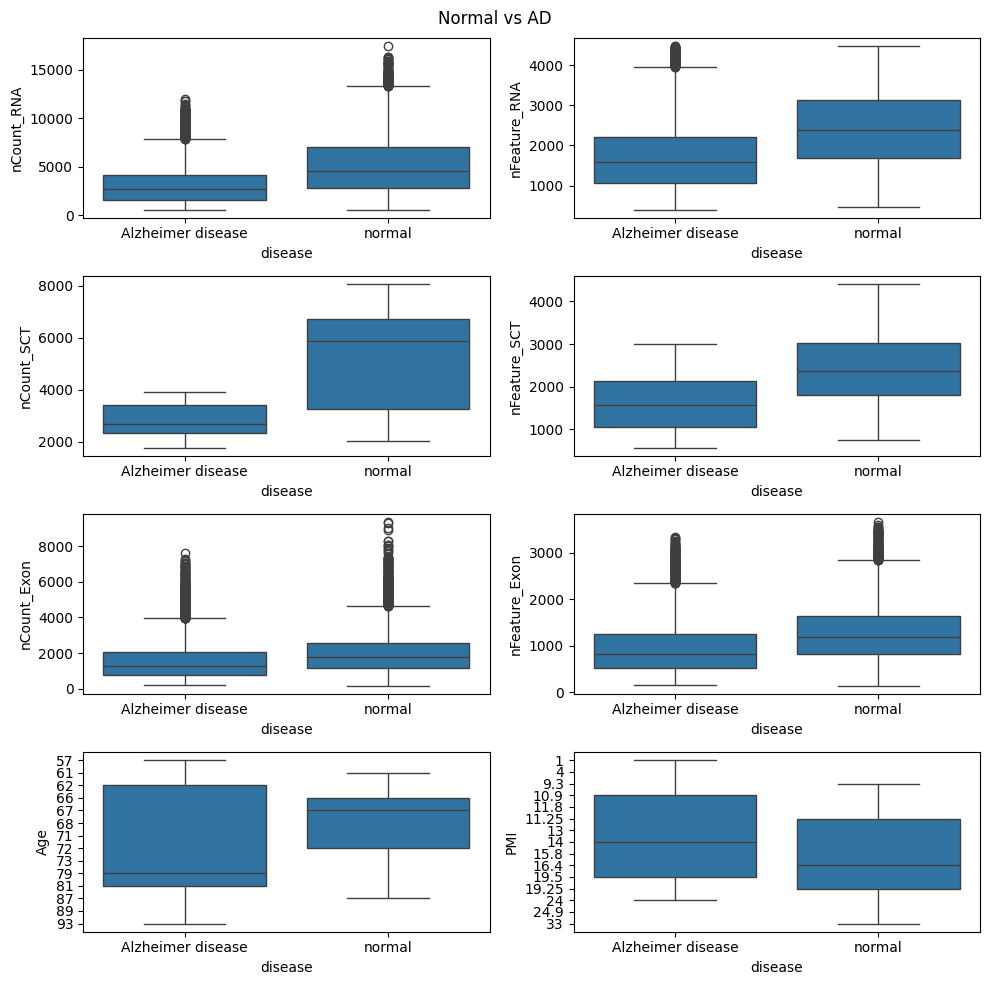

---

### **Next Steps**

- Perform **differential gene expression analysis** to identify significant gene markers between control and AD groups.
- Explore pathways linked to reduced RNA metrics in AD.


In [ ]:
# Cell count for AD vs Normal
adata.obs.disease.value_counts()

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64

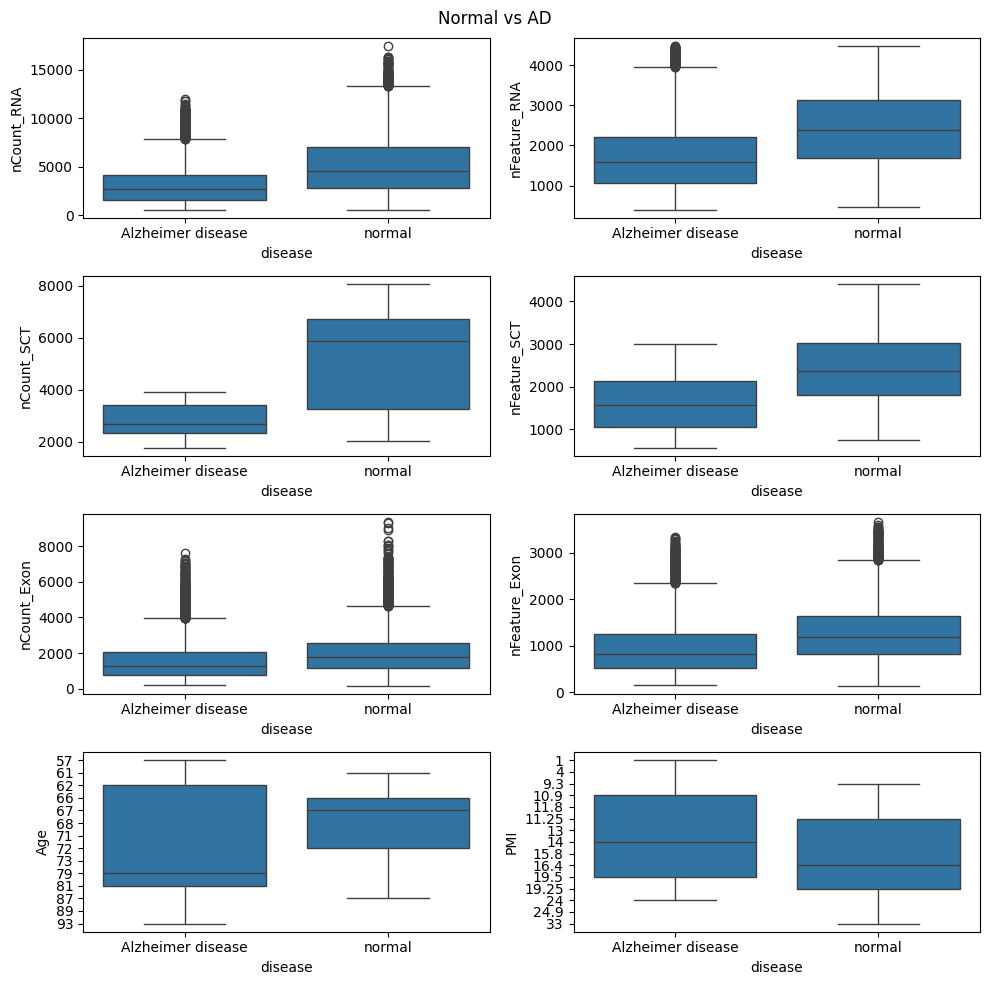

In [ ]:
# Plotting AD vs Normal
fig, axs = plt.subplots(4,2, figsize=(10,10))
fig.suptitle('Normal vs AD')
sns.boxplot(ax=axs[0,0],x="disease", y="nCount_RNA", data=adata.obs)
sns.boxplot(ax=axs[0,1],x="disease", y="nFeature_RNA", data=adata.obs)

sns.boxplot(ax=axs[1,0],x="disease", y="nCount_SCT", data=adata.obs)
sns.boxplot(ax=axs[1,1],x="disease", y="nFeature_SCT", data=adata.obs)

sns.boxplot(ax=axs[2,0],x="disease", y="nCount_Exon", data=adata.obs)
sns.boxplot(ax=axs[2,1],x="disease", y="nFeature_Exon", data=adata.obs)

sns.boxplot(ax=axs[3,0],x="disease", y="Age", data=adata.obs)
sns.boxplot(ax=axs[3,1],x="disease", y="PMI", data=adata.obs)
plt.tight_layout()


#**Clustering the by cell type**
The next important step is understanding the cells we are looking at. The Single Soma dataset contains 7 different cell types which overlayed on a Umap look like the image below.

---

Each of these cells is identified by two or three marker genes.

Eg.  ln7_ADARB2_CALB2 is identified by


* ADARB2: Often associated with neuronal populations, particularly GABAergic interneurons. It is an RNA-editing enzyme implicated in neurodevelopment and function.

* CALB2: Encodes calretinin, a calcium-binding protein frequently expressed in a subset of inhibitory interneurons. These cells are thought to be involved in regulating neural network oscillations and synchrony.

---
## **What do these tell us?**

The cell types represent various subtypes of inhibitory interneurons each with their own specific functions.  
* Network synchronization (e.g., PVALB).
* Local dendritic inhibition (e.g., SST- and LAMP5).
* Control of action potential initiation (e.g., chandelier cells).


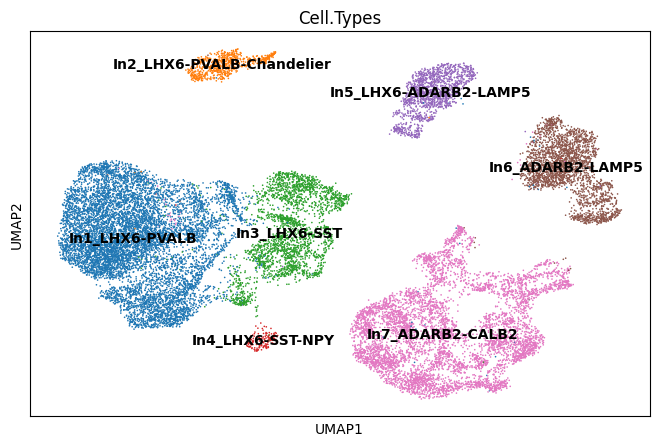

In [ ]:
rcParams["figure.figsize"] = (8, 5)
sc.pl.umap(adata, color="Cell.Types", wspace=0.4,legend_loc='on data')

#**Digging Deeper: Granular Clustering**
While visualizing cell types provides a high-level overview, true innovation comes from exploring deeper, more granular details in the dataset.

##**Clustering for Finer Insights**
To achieve this, we implemented the Leiden algorithm with a resolution of 0.5, further segmenting the dataset into smaller, more distinct cell clusters. This approach helps to uncover subtle differences within a group of cells that might otherwise go unnoticed.

For instance, the ADARB2-CALB2 cell type was subdivided into 9 distinct clusters.
This highlights significant variability in gene expression within this specific cell type



##**Stark Differences in Clusters**
When comparing UMAPs of the clusters, we observed stark differences in Cluster 20 (C20), for example.
In this case we would expect C20 to have a strong imbalance between Normal patients compared to AD

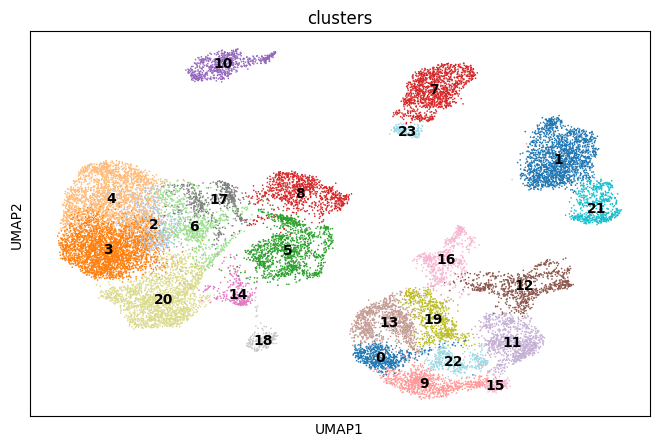

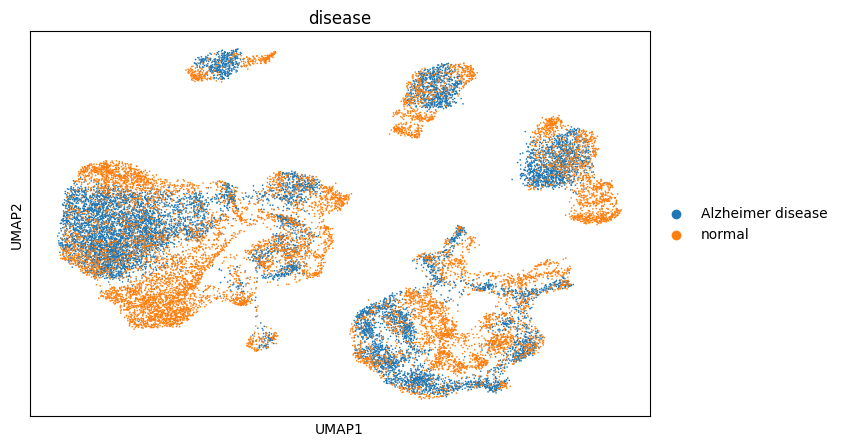

In [ ]:
sc.pl.umap(adata, color=["clusters"], wspace=0.4,legend_loc='on data',projection="2d",palette="tab20")
sc.pl.umap(adata, color=["disease"], wspace=0.4)

#**Statistical Hypothesis Test Selection**
We start by ranking Genes with different methods to gauge overlap and select the best method for the continued analysis. We also consulted literature and luckily our findings and the literature agreed.

## **Comparison of T-test and Wilcoxon Methods**

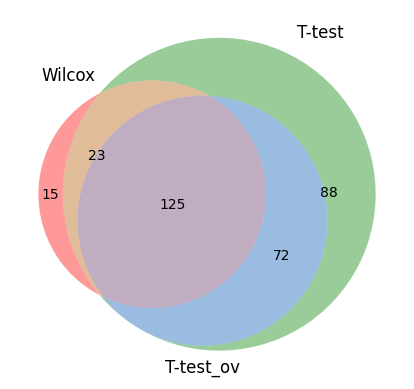

### **Overview of the Venn Diagram**  
The Venn diagram below illustrates the differences between the **T-test** and **Wilcoxon** methods in identifying genes:

- **Overlap**: Represents the genes identified by both methods.  
- **T-test**: Identifies a larger number of genes but may overestimate due to its sensitivity to outliers and assumptions about data distribution.  
- **Wilcoxon Method**: Identifies fewer genes overall but shows a high overlap with other methods, indicating robust and conservative performance.

### **Key Insights**:
1. **Wilcoxon Identifies Fewer Genes**:  
   While the Wilcoxon method identifies fewer genes compared to the T-test, it maintains a high overlap with other methods. This suggests that the T-test might overestimate significant results.

2. **Wilcoxon as the Preferred Method**:  
   Our **literature review** indicates that the **Wilcoxon test** is the default method used in many research studies. Based on its robustness and conservative nature, we chose Wilcoxon for our analysis.

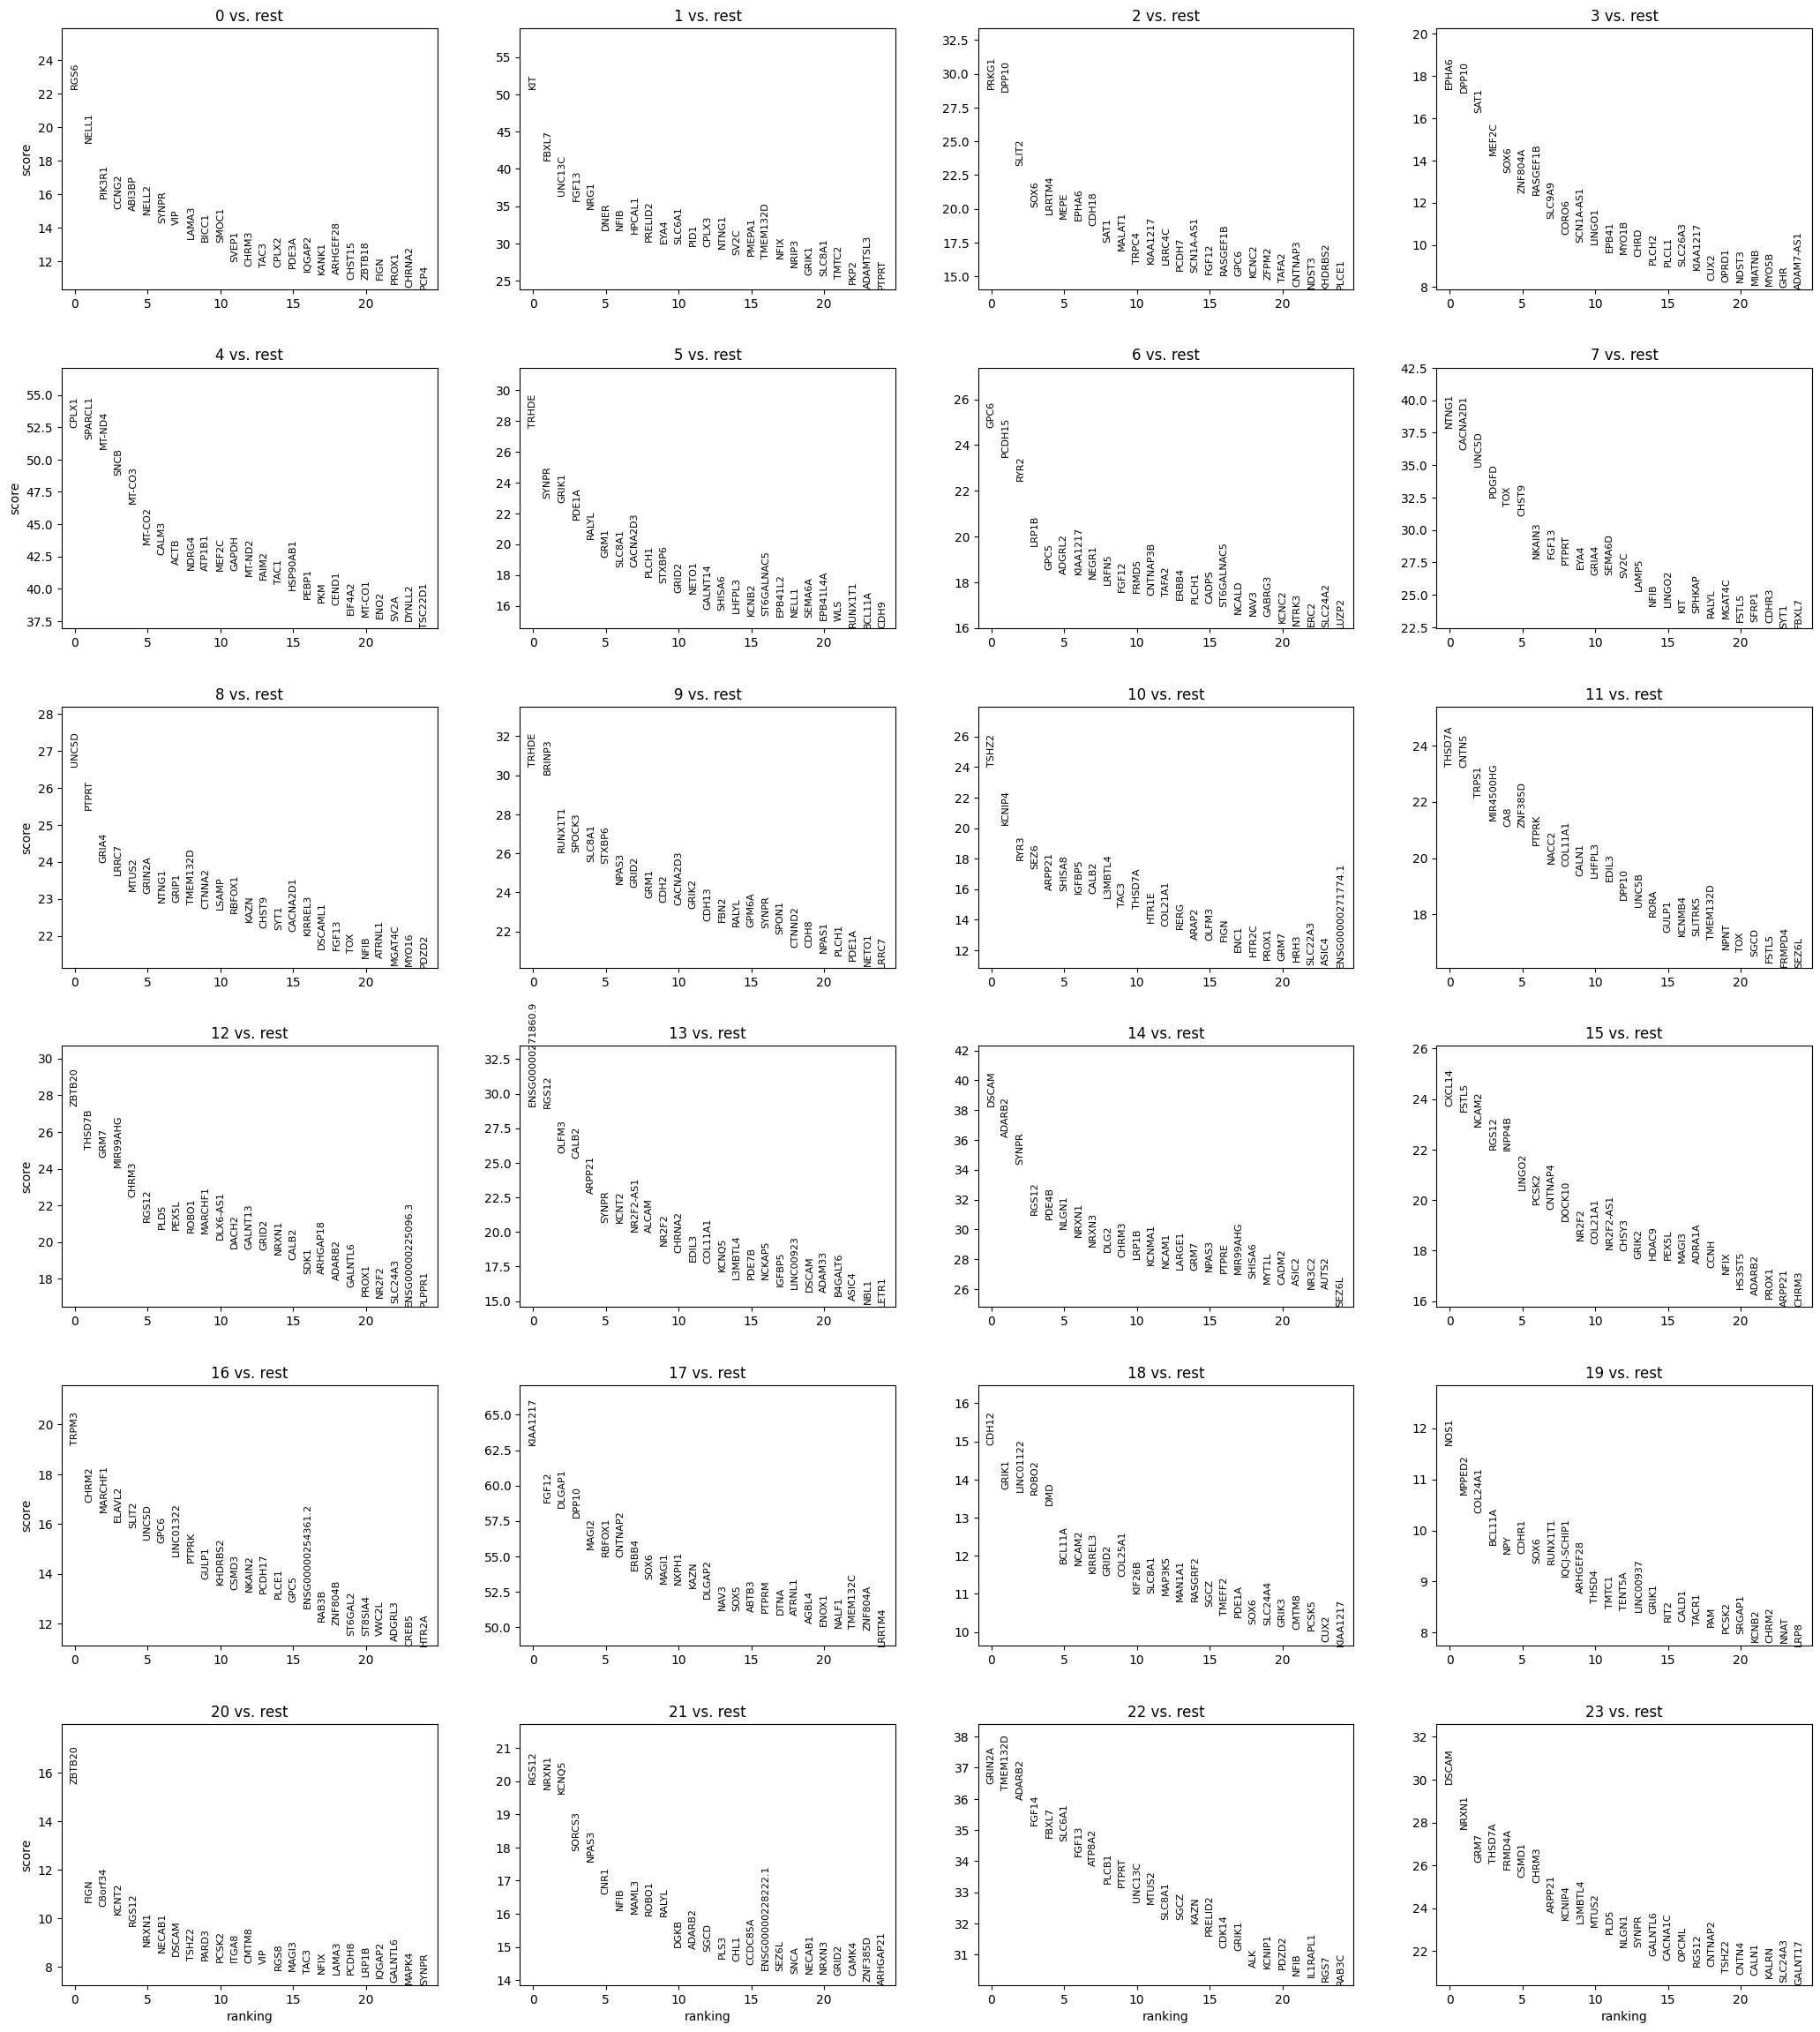

In [ ]:
# T-test
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test",gene_symbols='feature_name')

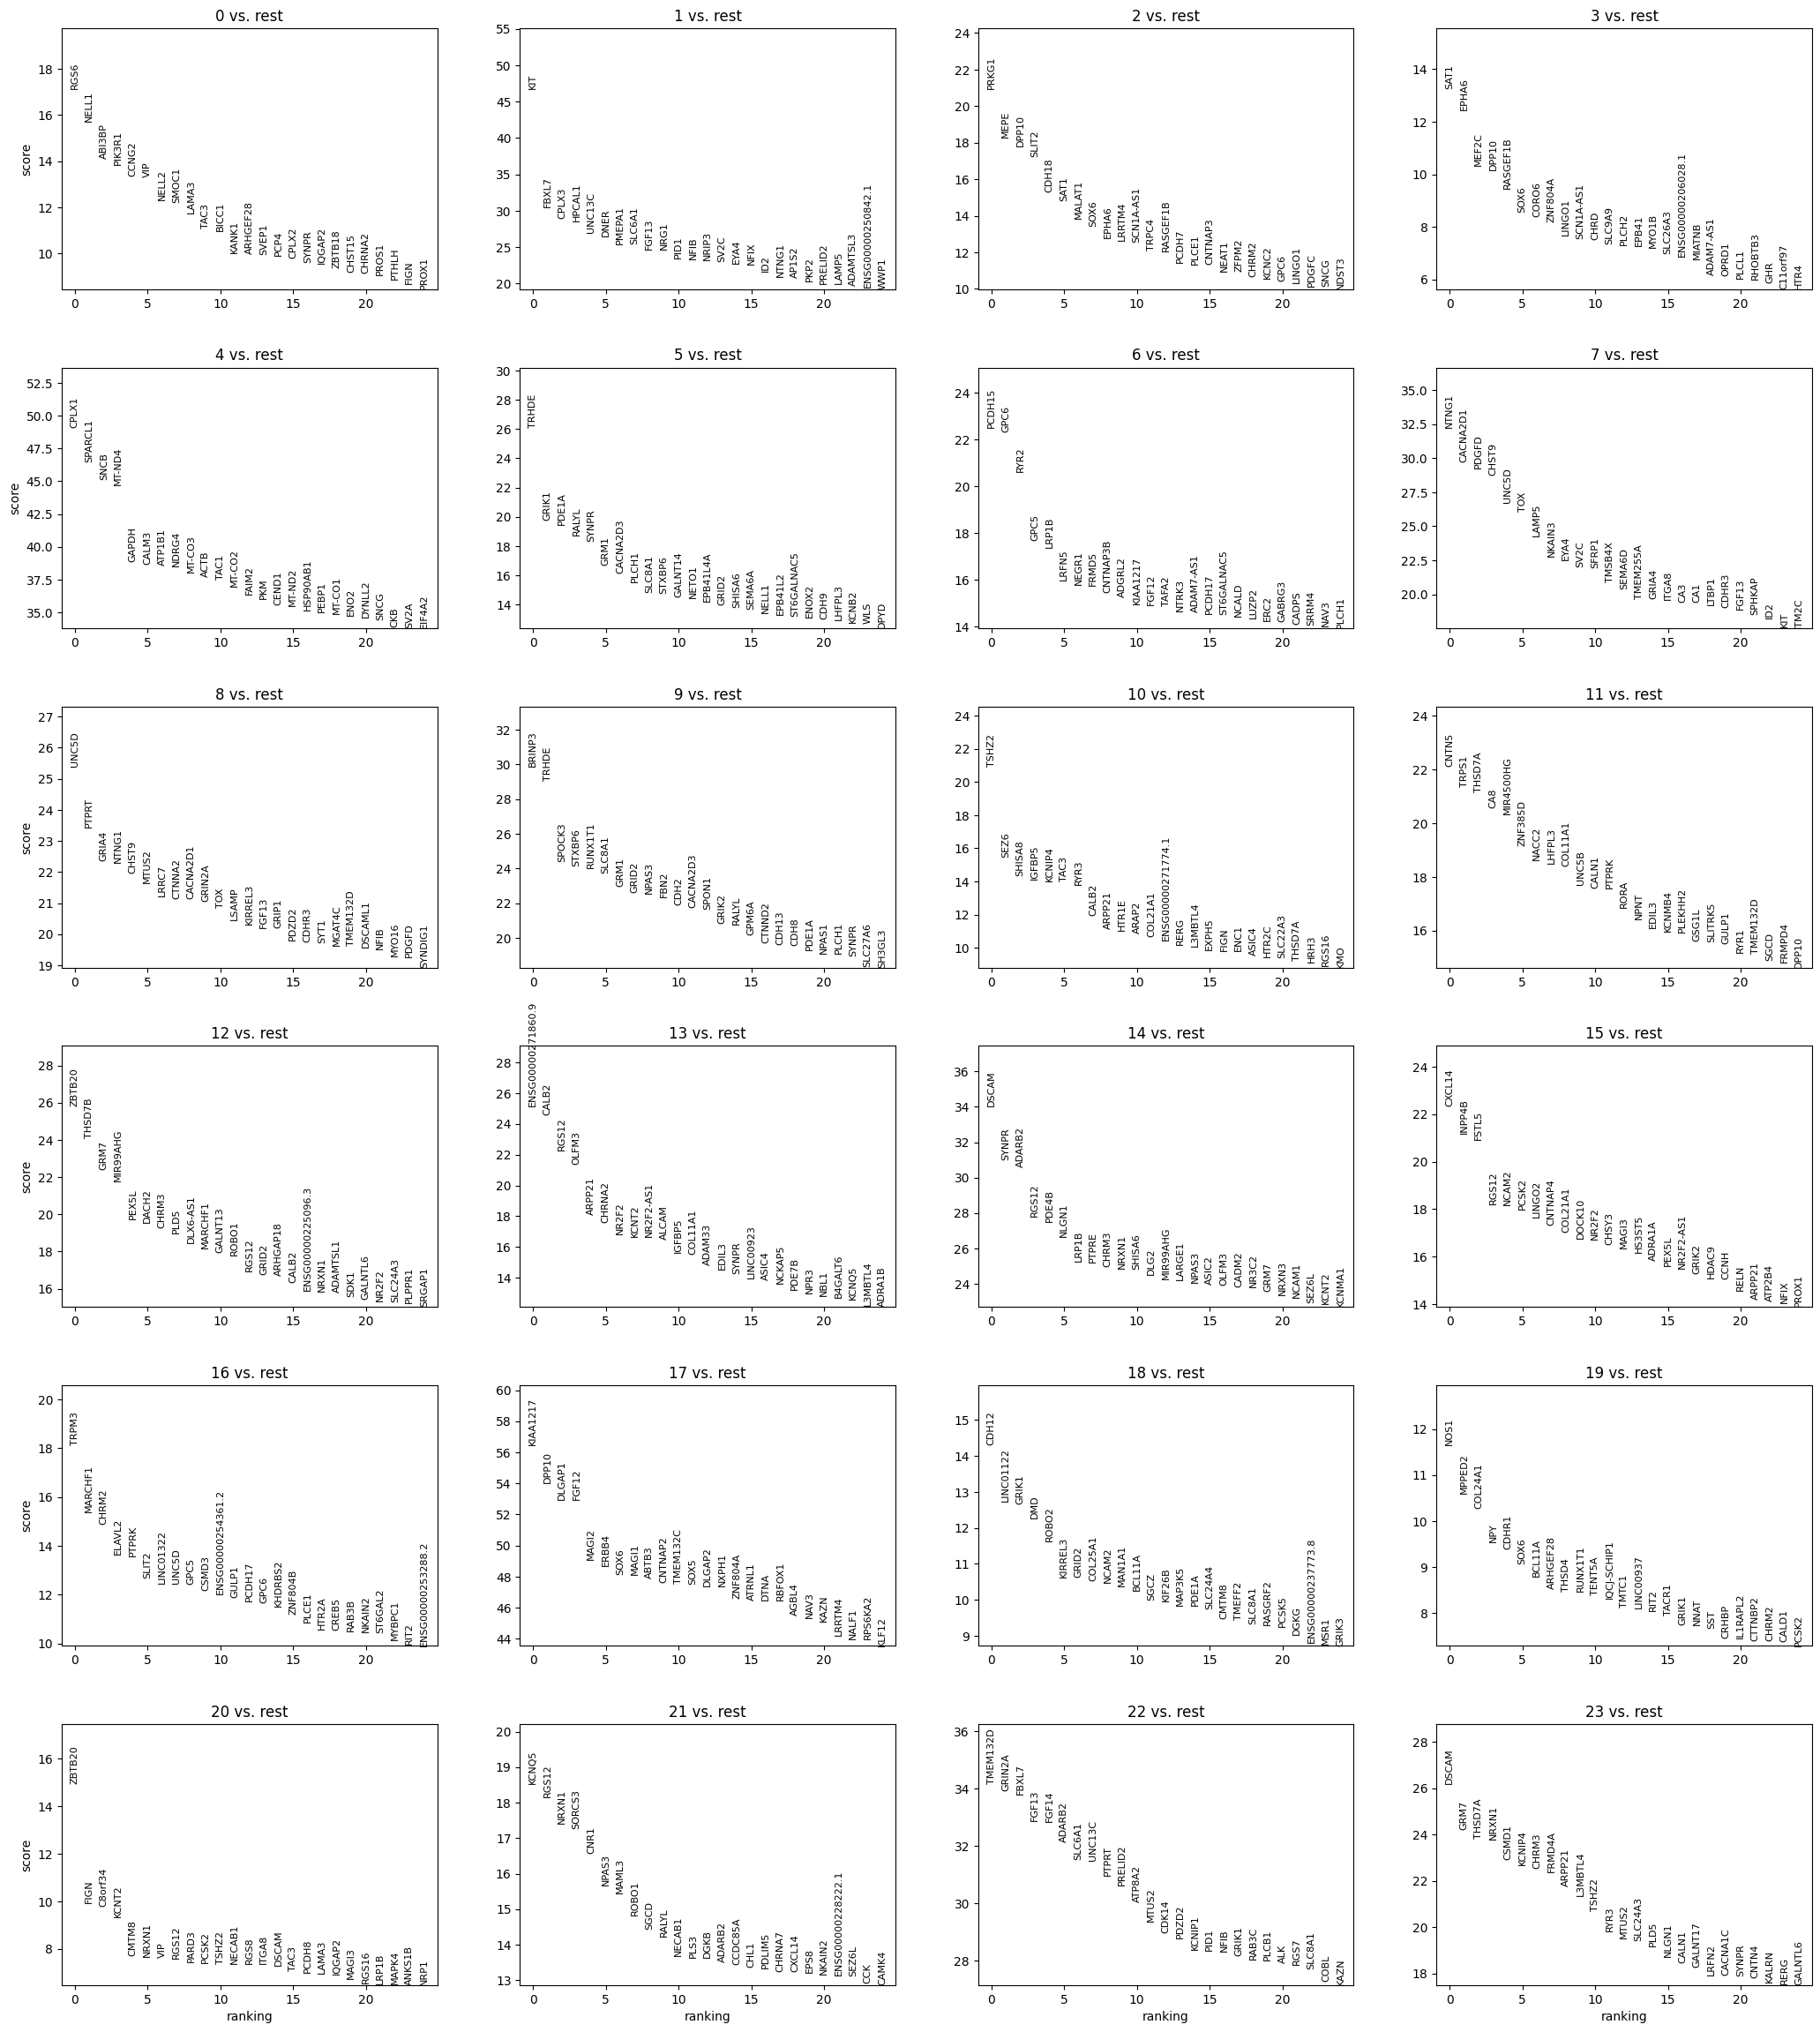

In [ ]:
# T-test overestimated_variance
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov",gene_symbols='feature_name')

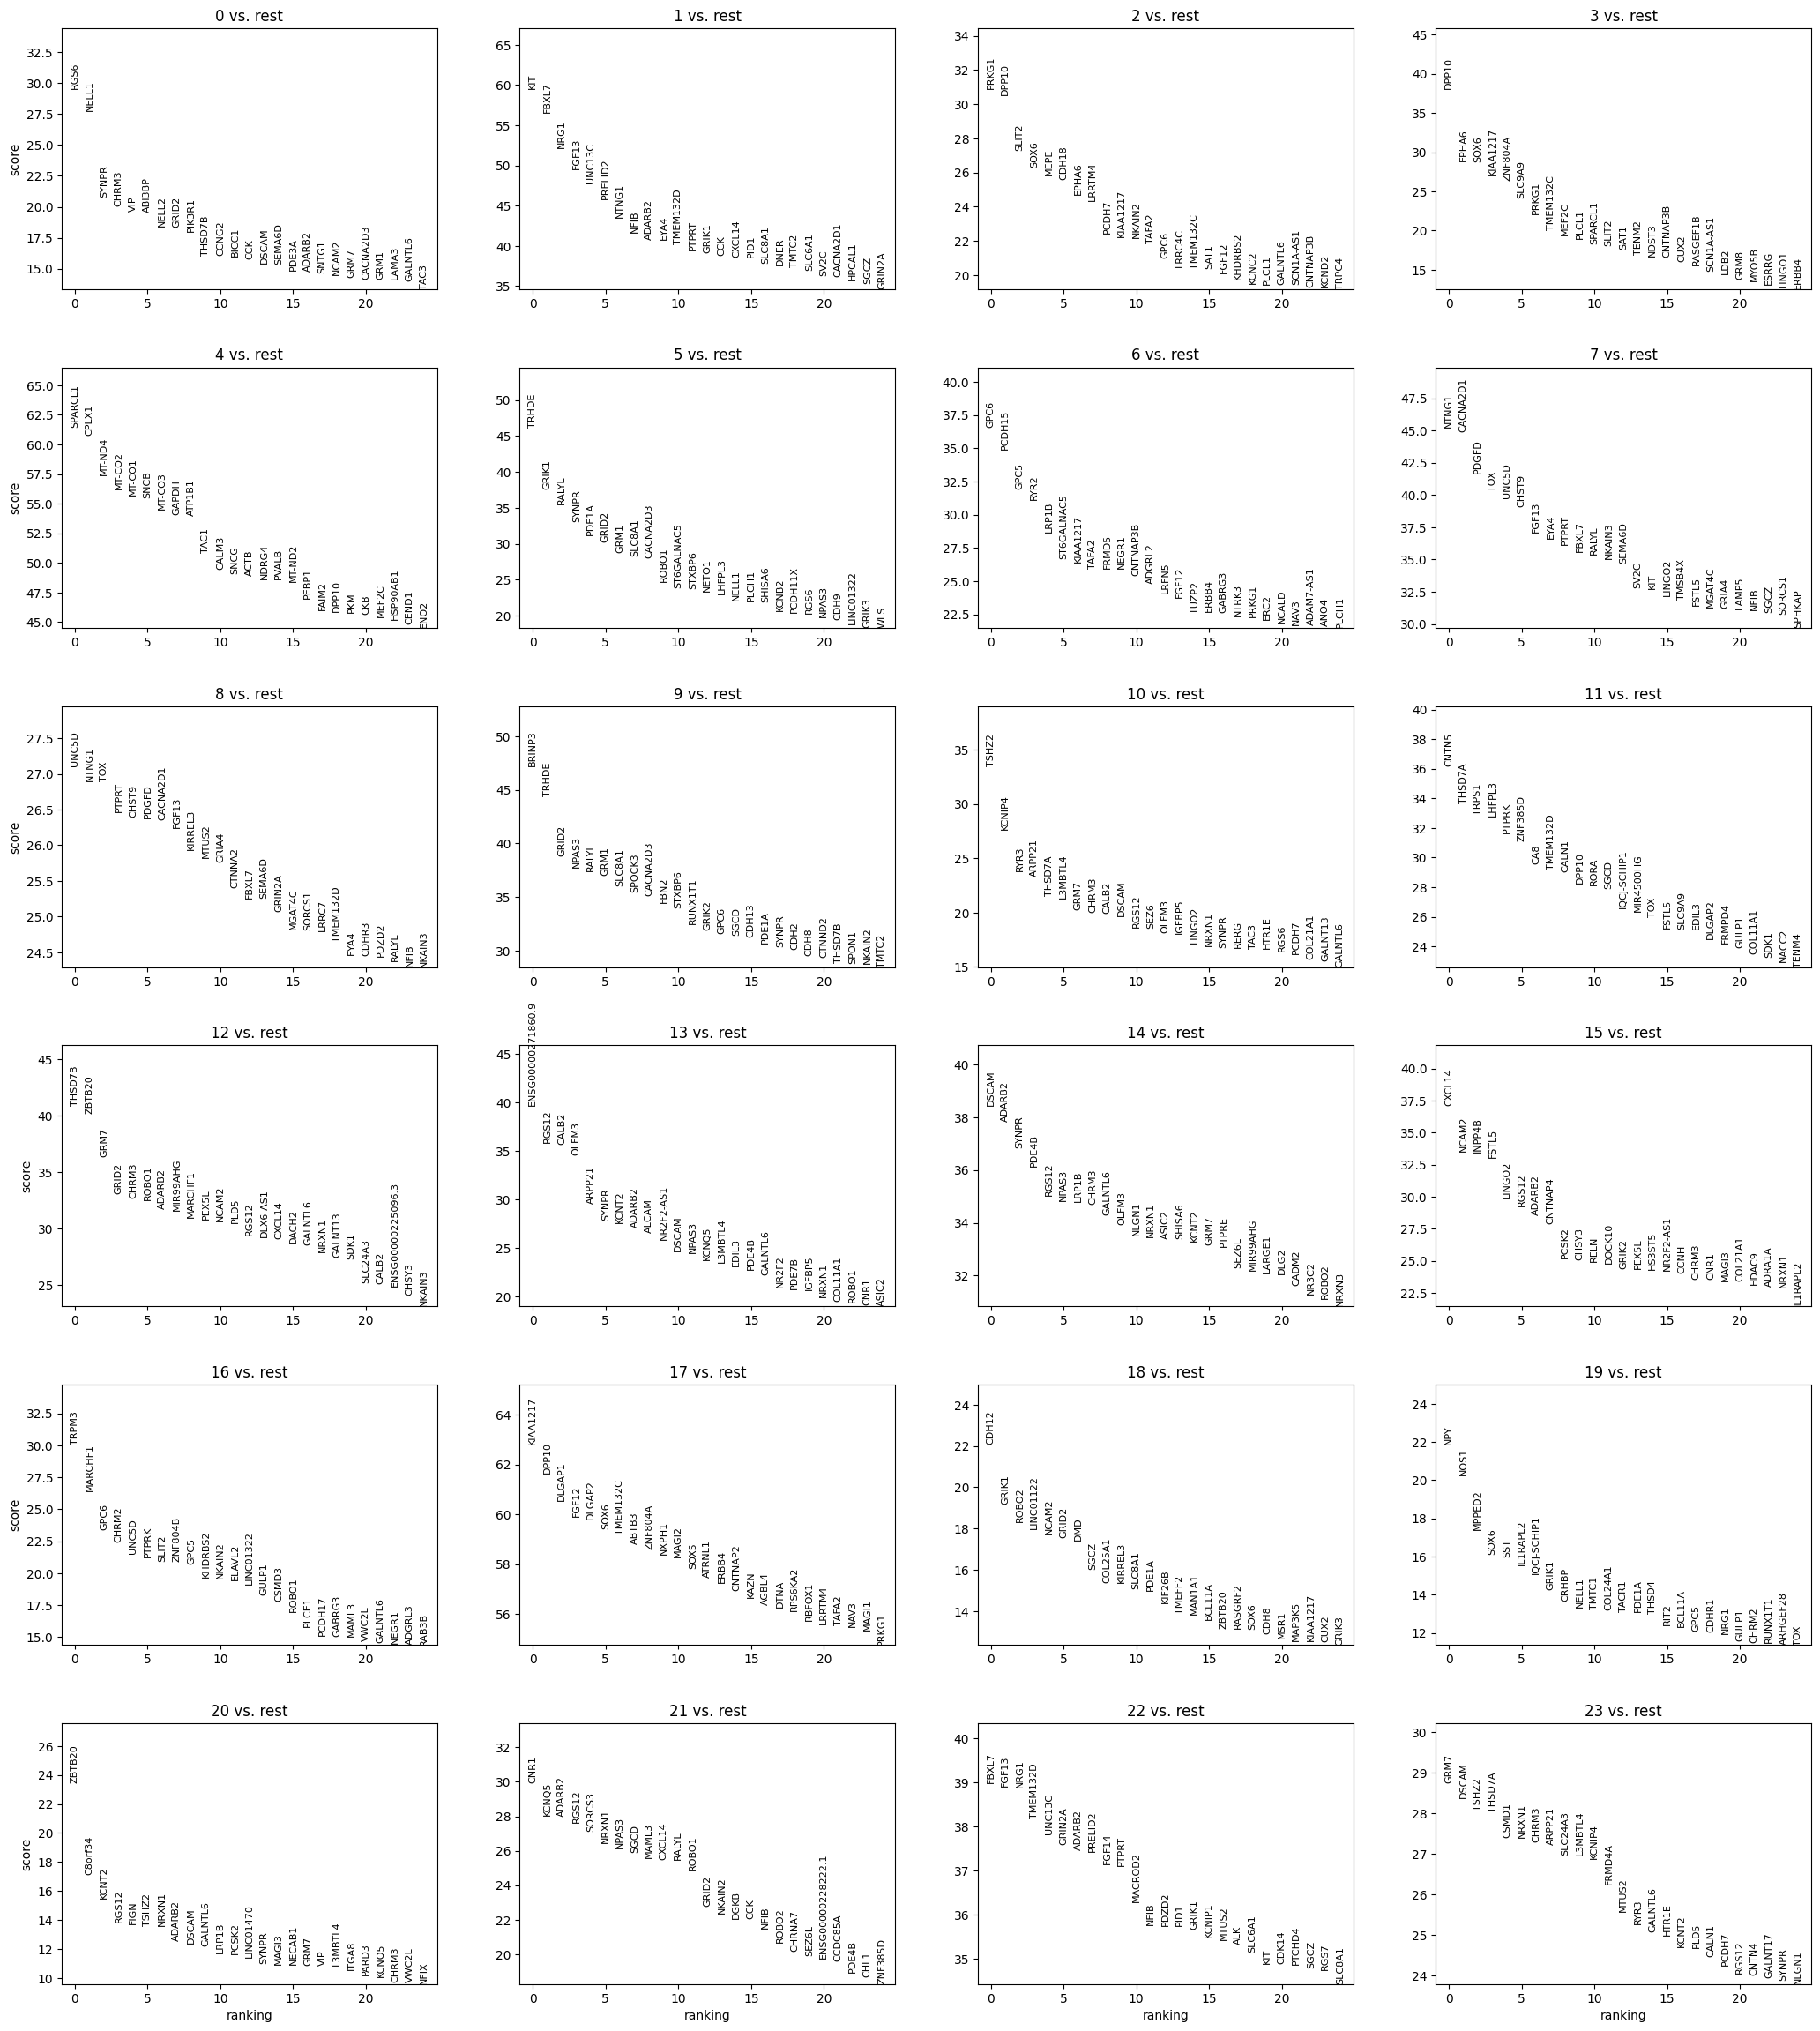

In [ ]:
# Wilcoxon
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon",gene_symbols='feature_name')

In [ ]:
# Logistic Regression
sc.tl.rank_genes_groups(adata, 'clusters', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg", gene_symbols='feature_name')

KeyboardInterrupt: 

This VENN diagram illustrates the differences between the two T-test and Wilcoxon methods.

The Overlap represents the genes that were identified by all methods.

While wilcoxon identified the least genes in general it exhibits a high overlap with the other methods which indicates an overestimation of the T-test.

From our literature review we also concluded that Wilcoxon is the default method used by many papers and therefore we chose Wilcoxon.

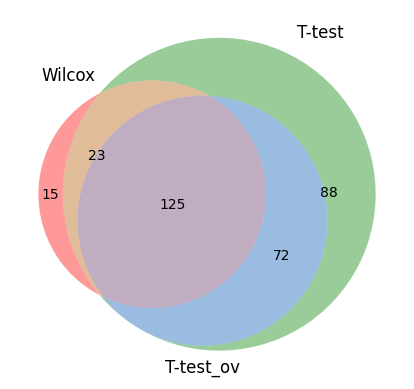

In [ ]:
#Venn 3
wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

# **Quantifying Differences**

### **Returning to the Core Question**  
How can we **quantify the differences** in cell expression for clusters that differ most between **Alzheimer’s disease (AD)** and **control** groups?

### **Applying Occam’s Razor**  
To simplify the problem, we focus on the proportions of cells within each cluster:  
- **How many cells in a given cluster belong to AD?**  
- **How many cells belong to the control group?**

By comparing these proportions across clusters, we can identify which clusters show the most significant imbalances between the two groups.

---

### **Proportional Analysis**  
Using this approach, we calculated the proportions of AD and control cells for each cluster. These proportions are visualized in the graph below:


---

### **Key Observations**  
1. Clusters with larger imbalances in proportions indicate regions of significant variation in cell expression between AD and control groups.  
- 4 clusters are heavily slanted towards AD with more than 75% of cells sample being from AD patients
- 5 clusters that are slanted by 99% to the control group.
2. These imbalanced clusters are potential candidates for further investigation, as they may highlight critical biological differences related to AD progression.

### **Next Steps**  
By analyzing these proportions, we can investigate the gene expression profiles of these clusters to uncover disease-specific markers or pathways.


Text(0.5, 1.0, 'Cluster Proportions by Disease')

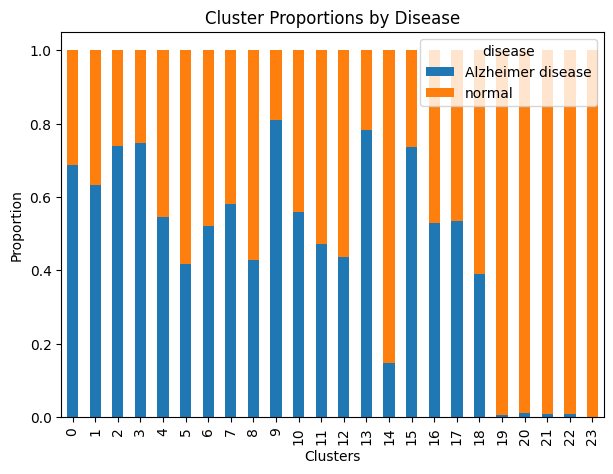

In [ ]:
cluster_counts = pd.crosstab(adata.obs['clusters'], adata.obs['disease'])
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)
cluster_proportions.plot(kind='bar', stacked=True,figsize=(7,5))
plt.xlabel('Clusters')
plt.ylabel('Proportion')
plt.title('Cluster Proportions by Disease')


As we can see here are the cell clusters whose cells most closely correlate with the disease status.

To put it into leymans terms:
On a umap that flattens very high-dimensional data to 2D, cells that are close to each other have similar gene expressions. Large clusters are explained by cell types but more granular analysis revealed sub-clusters. Within these clusters of cells with similar gene expression there are stark differences in the proportions with which these cells can be found.

What does this tell us?

If we can identify clusters that most strongly differ from AD to control, a differential gene expression analysis could identify which genes are particularly interesting. This would allow us to find a set of genes whose up or down regulation could lead to insights into the diease progression and potentially show us which genes are most impactful for the prediction of AD.





In [ ]:
print(cluster_proportions.sort_values(by='Alzheimer disease', ascending=False).head(5))
print(cluster_proportions.sort_values(by='normal', ascending=False).head(5))


ds_cluster_ids = cluster_proportions.sort_values(by='Alzheimer disease', ascending=False).head(5).index.tolist()
norm_cluster_ids = cluster_proportions.sort_values(by='normal', ascending=False).head(5).index.tolist()

print("____________________________________________")
print(f"Disease Specific: {ds_cluster_ids}")
print(f"Normal Specific: {norm_cluster_ids}")

ds_clusters = adata[adata.obs.clusters.isin(ds_cluster_ids)]
norm_clusters = adata[adata.obs.clusters.isin(norm_cluster_ids)]

print("____________________________________________")
print(f"Disease Specific Subset: {ds_clusters.shape}")
print(f"Normal Subset:           {norm_clusters.shape}")

disease   Alzheimer disease  normal
clusters                           
9                      0.81    0.19
13                     0.78    0.22
3                      0.75    0.25
2                      0.74    0.26
15                     0.74    0.26
disease   Alzheimer disease  normal
clusters                           
23                     0.00    1.00
19                     0.01    0.99
22                     0.01    0.99
21                     0.01    0.99
20                     0.01    0.99
____________________________________________
Disease Specific: ['9', '13', '3', '2', '15']
Normal Specific: ['23', '19', '22', '21', '20']
____________________________________________
Disease Specific Subset: (5319, 4477)
Normal Subset:           (3669, 4477)


In [ ]:

adata.obs.groupby("clusters")["disease"].value_counts()


clusters  disease          
0         Alzheimer disease     409
          normal                187
1         Alzheimer disease    1202
          normal                694
2         Alzheimer disease     351
          normal                124
3         Alzheimer disease    2137
          normal                728
4         Alzheimer disease    1214
          normal               1009
5         normal                762
          Alzheimer disease     544
6         Alzheimer disease     406
          normal                372
7         Alzheimer disease     716
          normal                518
8         normal                537
          Alzheimer disease     402
9         Alzheimer disease     661
          normal                154
10        Alzheimer disease     390
          normal                308
11        normal                494
          Alzheimer disease     439
12        normal                453
          Alzheimer disease     352
13        Alzheimer disease     787
          normal                217
14        normal                226
          Alzheimer disease      39
15        Alzheimer disease     118
          normal                 42
16        Alzheimer disease     306
          normal                272
17        Alzheimer disease     271
          normal                236
18        normal                107
          Alzheimer disease      68
19        normal                639
          Alzheimer disease       4
20        normal               1844
          Alzheimer disease      20
21        normal                584
          Alzheimer disease       5
22        normal                416
          Alzheimer disease       3
23        normal                154
          Alzheimer disease       0
Name: count, dtype: int64

These are the clusters ranked and by their proportial gene expression. We can see that 4 clusters are heavily slanted towards AD with more than 75% of cells sample being from AD patients

Similarly for we see 5 clusters that are slanted by 99% to the control group.

How can we trust this?

If we assume that gene expression in clusters is normally distributed then we can formulate the following Null Hypothesis:

H0: The distribution of AD and normal is independent of clusters. There is no significant association between cell clusters and the disease status.


H1: There is a significant association between the clusters and the disease status.

In [ ]:
def f(a,b):
  if a in ds_cluster_ids:
    return "ds"
  elif a in norm_cluster_ids:
    return "norm"
  else:
    return b

adata.obs['cluster_group'] = None
adata.obs["cluster_group"] = adata.obs.apply(lambda x: f(x['clusters'],x["cluster_group"]),axis=1)

In [ ]:
#Chi Squared Test
chi = scipy.stats.chi2_contingency(cluster_counts)
chi

Chi2ContingencyResult(statistic=5514.260856025541, pvalue=0.0, dof=23, expected_freq=array([[ 294.83253501,  301.16746499],
       [ 937.92363487,  958.07636513],
       [ 234.97559418,  240.02440582],
       [1417.273847  , 1447.726153  ],
       [1099.68578076, 1123.31421924],
       [ 646.05921263,  659.94078737],
       [ 384.86528899,  393.13471101],
       [ 610.4418594 ,  623.5581406 ],
       [ 464.50964828,  474.49035172],
       [ 403.16865107,  411.83134893],
       [ 345.29045208,  352.70954792],
       [ 461.54153551,  471.45846449],
       [ 398.22179645,  406.77820355],
       [ 496.66420328,  507.33579672],
       [ 131.09164728,  133.90835272],
       [  79.14967383,   80.85032617],
       [ 285.92819671,  292.07180329],
       [ 250.80552894,  256.19447106],
       [  86.56995575,   88.43004425],
       [ 318.0827517 ,  324.9172483 ],
       [ 922.0937001 ,  941.9062999 ],
       [ 291.36973678,  297.63026322],
       [ 207.27320834,  211.72679166],
       [  76.18156

The P-value of 0 indicates that the probability of observing the data is virtually 0. In other words we can be very certain that these observations are not by pure chance.

In [ ]:
#Permutation Test
group1="Alzheimer disease"
group2="normal"

result = pt.permutation_test(
    adata,
    group1,
    group2,
    group_col='disease',
    cell_type_col='clusters',
    nperm=1000,
    alpha=0.05,
    n_bootstrap=1000,
    verbose=True

)

Processing cell types: 100%|██████████| 24/24 [10:30<00:00, 26.26s/it]


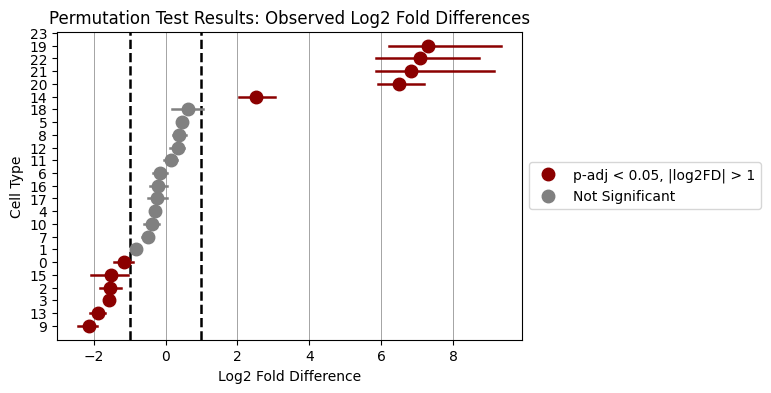

In [ ]:
#Plot Permutation Test
plot = pt.point_range_plot(result, figsize=(6,4))


A second method of validation is the permutation test. A permutation test is a non-parametric statistical test used to evaluate whether the observed differences between two groups (e.g., "Alzheimer's disease" and "normal") are statistically significant, assuming no specific distribution of the data.

If the observed association between disease status and clusters is significantly stronger than what is expected under random permutations, the null hypothesis is rejected.

This is exaclty what we can observe above. The clusters to either side of the dotted line are clusters that we identified for our investigation. Clusters to the right (23,19,22, etc) are normal specific and clusters to the left (9,13,3,2,etc) are disease specific.

This suggests that the clustering patterns are significantly associated with disease status, highlighting a meaningful biological difference.


#**Gene Expression Analysis**

The next step is to compare the gene expression of the cluster groups. What makes these clusters different?

In the images below we can see the gene expression differences with the specific group between AD and control.

| 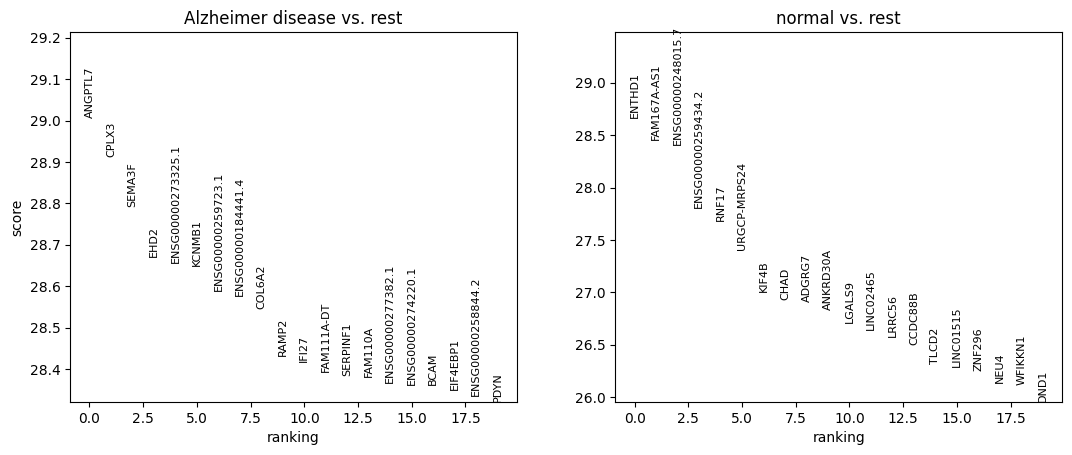 | 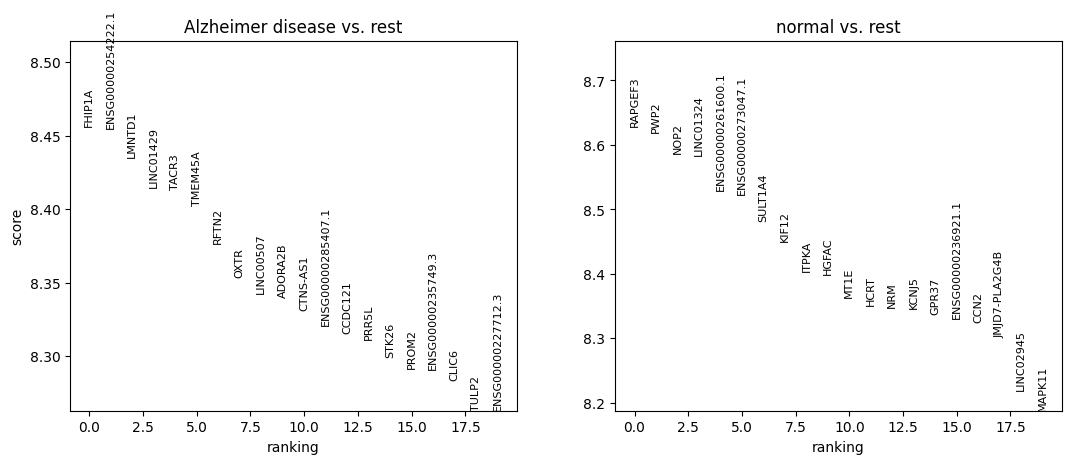 |
|---|---|
| disease clusters | normal clusters |

Additionally, we also found the expression data for the dataset as a whole
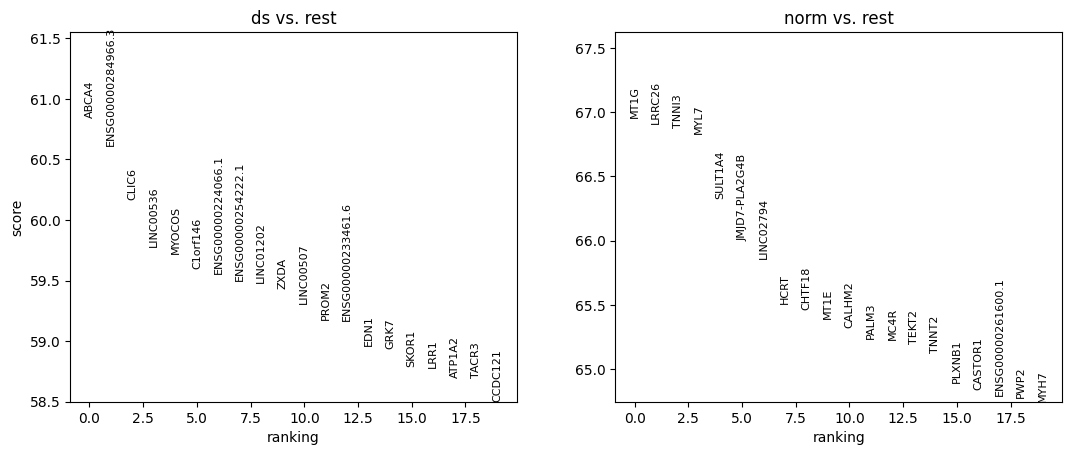

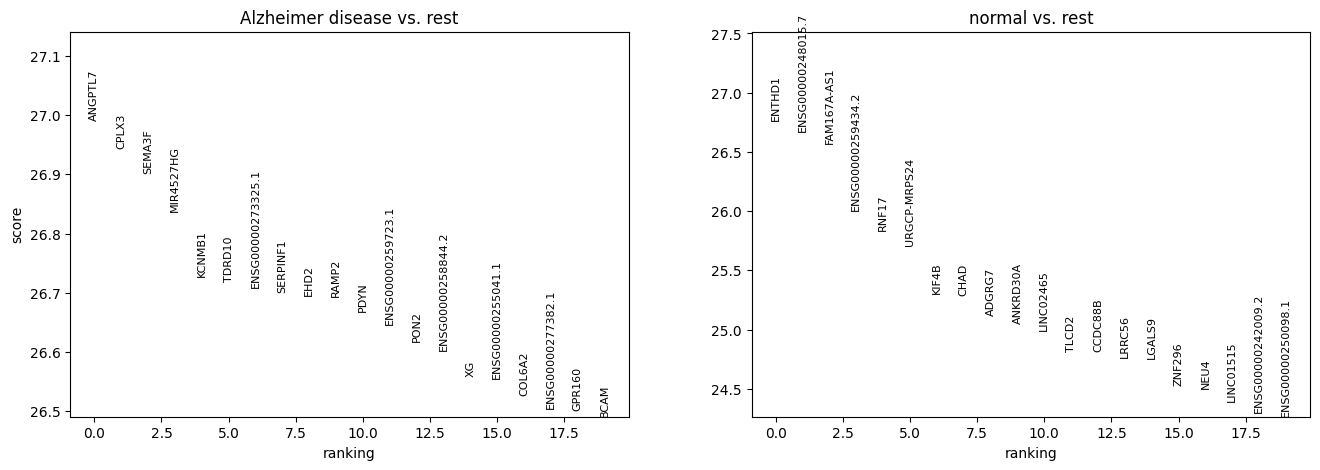

In [ ]:
#Disease Specific Clusters
sc.tl.rank_genes_groups(ds_clusters, 'disease', method='wilcoxon', key_added = "wilcoxon",use_raw=False)
sc.pl.rank_genes_groups(ds_clusters, n_genes=20, sharey=False, key="wilcoxon",gene_symbols='feature_name')

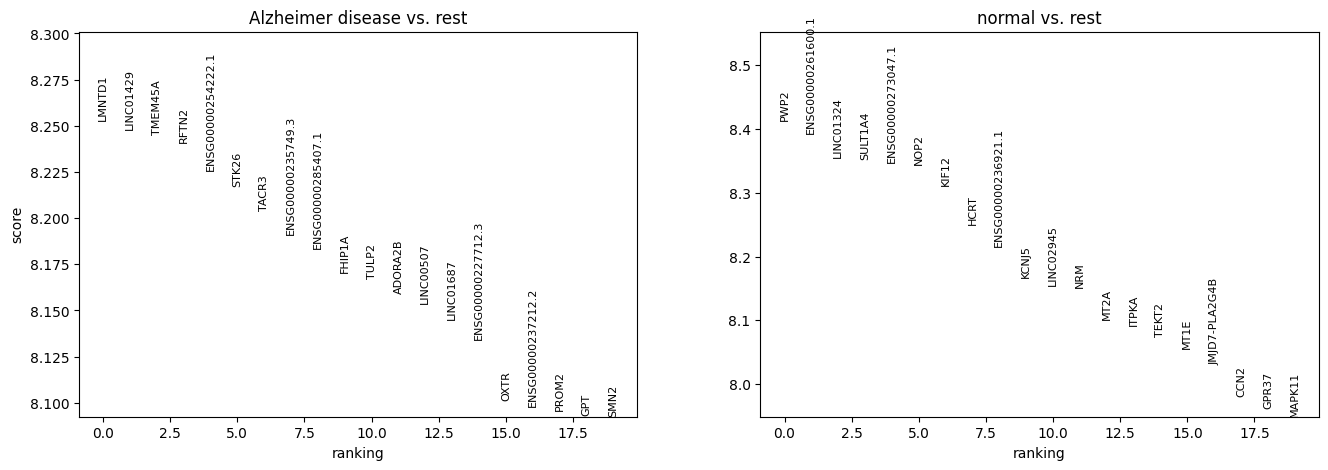

In [ ]:
#Normal Clusters
sc.tl.rank_genes_groups(norm_clusters, 'disease', method='wilcoxon', key_added = "wilcoxon",use_raw=False)
sc.pl.rank_genes_groups(norm_clusters, n_genes=20, sharey=False, key="wilcoxon",gene_symbols='feature_name')


So how do we check the difference between our clusters and the general cell population?



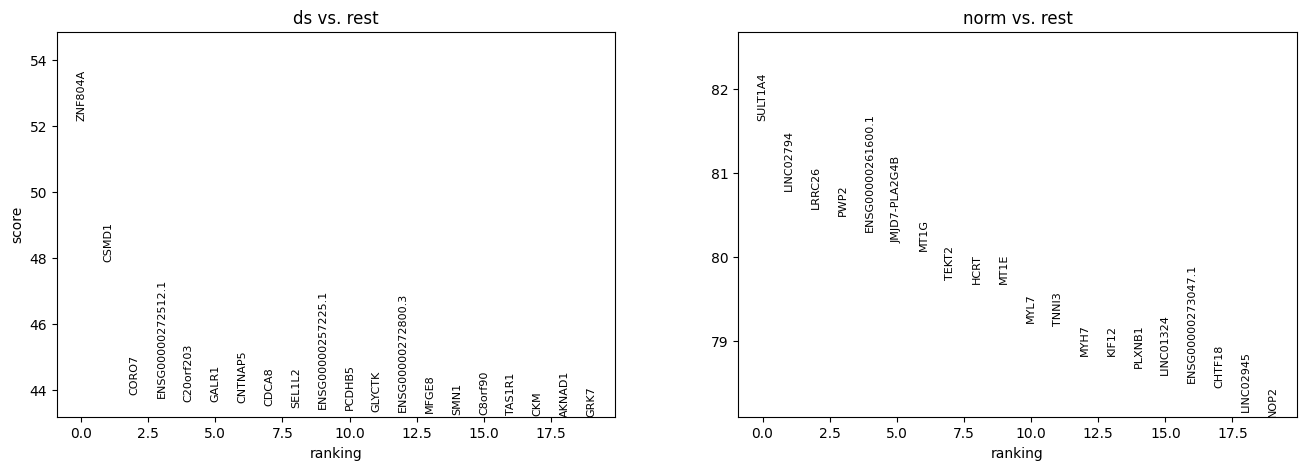

In [ ]:
#Cluster groups compared to all clusters
sc.tl.rank_genes_groups(adata, 'cluster_group', method='wilcoxon', key_added = "wilcoxon",use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key="wilcoxon",gene_symbols='feature_name')

And how can we validate that these genes are more relevant to our investigation than simply taking the most differently expressed genes across the whole dataset?

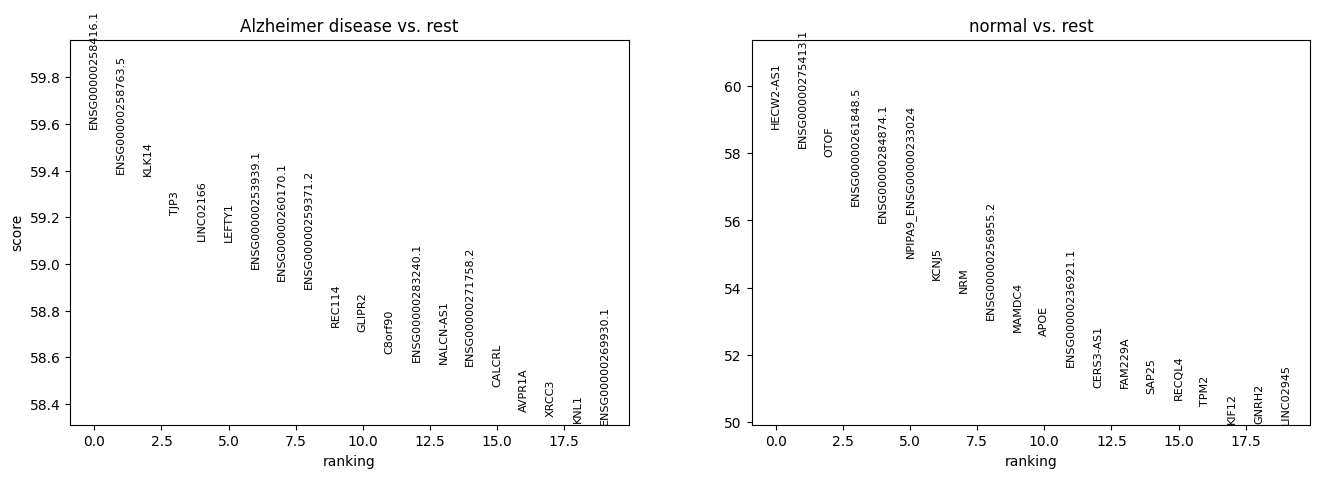

In [ ]:
#general gene expression for all clusters by disease
sc.tl.rank_genes_groups(adata, 'disease', method='wilcoxon', key_added = "adata_rank",use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key="adata_rank",gene_symbols='feature_name')

# **Findings**

### **Key Observations from the Analysis**  
1. **Genes with Moderate Expression Across Multiple Clusters**:  
   - Some genes were highly expressed in clusters that do not strongly correlate with Alzheimer’s disease (AD).  
   - These genes exhibit moderate expression across multiple clusters that lack a dominant proportion of AD or control cells.  

2. **Impact on Gene Identification**:  
   - The high expression of these genes in balanced clusters can obscure the detection of genes uniquely expressed in **AD-dominant** or **control-dominant** clusters.  
   - This noise complicates efforts to identify clear biomarkers associated with AD progression.

---

### **Refined Analysis Approach**  
To mitigate this issue, we adjusted our analysis by independently examining clusters based on their composition:  
- **Balanced Clusters**: Clusters with a near-equal proportion of AD and control cells.  
- **Control-Dominant Clusters**: Clusters with a majority of control cells.  
- **AD-Dominant Clusters**: Clusters with a majority of AD cells.  

### **Objective**  
By isolating the balanced clusters and focusing separately on control- and AD-dominant clusters, we aim to:  
- **Reduce noise** from genes expressed broadly in balanced clusters.  
- **Identify distinct markers** for the onset and progression of AD.


##Choosing the genes

To choose the genes all we did is take the top differently expressed genes for each of these "categories" as such we took the top 20 genes disease and normal specific clusters as well as the top 20 DE genes without clustering.  



In [ ]:
norm_genes = sc.get.rank_genes_groups_df(adata, group='norm', key='wilcoxon')['names'][:20].map(gene_alias)
ds_genes = sc.get.rank_genes_groups_df(adata, group='ds', key='wilcoxon')['names'][:20].map(gene_alias)

nc_norm_genes = sc.get.rank_genes_groups_df(adata, group='normal', key='adata_rank')['names'][:20].map(gene_alias)
nc_ds_genes = sc.get.rank_genes_groups_df(adata, group='Alzheimer disease', key='adata_rank')['names'][:20].map(gene_alias)


In [ ]:
adata.X.shape

(21921, 4477)

#**ML Analysis #1**


So what can we do with these genes. First of all we try to subset the dataset to reduce the number of features from the already reduced 4477 to something more manageable. To do this we split the dataset into different sets.

For this analysis we chose to subset into:
* **Disease Specific Subset** - genes identified by comparing gene expression within ds clusters to the rest

* **Normal Specific Subset** - genes identified by comparing gene expression with norm clusters to the rest

* **Both** - the two of them combined

* **All (benchmark 1)** - all genes or features

* **Neither (benchmark 2)** - all genes except those identified

## **Disease Specific Subset**

In [ ]:
ds_data = adata[:,ds_genes.map(gene_aliases).tolist()]
print(ds_data.obs.disease.value_counts())
# Dieases Specific Genes
X = pd.DataFrame(ds_data.X)
y = ds_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = LazyClassifier(predictions=True)
ds_model_1, predictions = clf.fit(X_train, X_test, y_train, y_test)
ds_model_1["experiment"] = "DS"
ds_model_1

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 20) (4385, 20) (17536,) (4385,)


100%|██████████| 31/31 [01:09<00:00,  2.23s/it]

[LightGBM] [Info] Number of positive: 8910, number of negative: 8626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 17536, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508098 -> initscore=0.032393
[LightGBM] [Info] Start training from score 0.032393


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.76               0.76     0.76      0.76   
XGBClassifier                      0.76               0.76     0.76      0.76   
LGBMClassifier                     0.76               0.76     0.76      0.76   
ExtraTreesClassifier               0.75               0.75     0.75      0.75   
BaggingClassifier                  0.74               0.74     0.74      0.74   
AdaBoostClassifier                 0.69               0.69     0.69      0.69   
DecisionTreeClassifier             0.68               0.68     0.68      0.68   
ExtraTreeClassifier                0.67               0.67     0.67      0.67   
LabelPropagation                   0.67               0.67     0.67      0.67   
LabelSpreading                     0.67               0.67     0.67      0.67   
KNeighborsClassifier               0.66               0.66     0.66      0.66   
SVC                                0.66               0.66     0.66      0.66   
NuSVC                              0.66               0.66     0.66      0.65   
SGDClassifier                      0.56               0.56     0.56      0.55   
PassiveAggressiveClassifier        0.52               0.52     0.52      0.49   
CalibratedClassifierCV             0.52               0.52     0.52      0.52   
LogisticRegression                 0.52               0.52     0.52      0.51   
LinearDiscriminantAnalysis         0.51               0.51     0.51      0.51   
RidgeClassifier                    0.51               0.51     0.51      0.51   
RidgeClassifierCV                  0.51               0.51     0.51      0.51   
LinearSVC                          0.51               0.51     0.51      0.51   
GaussianNB                         0.50               0.51     0.51      0.41   
QuadraticDiscriminantAnalysis      0.50               0.51     0.51      0.41   
BernoulliNB                        0.50               0.50     0.50      0.44   
NearestCentroid                    0.50               0.50     0.50      0.50   
DummyClassifier                    0.49               0.50     0.50      0.33   
Perceptron                         0.45               0.45     0.45      0.45   

                               Time Taken experiment  
Model                                                 
RandomForestClassifier               8.29         DS  
XGBClassifier                        0.31         DS  
LGBMClassifier                       0.26         DS  
ExtraTreesClassifier                 1.88         DS  
BaggingClassifier                    3.63         DS  
AdaBoostClassifier                   2.63         DS  
DecisionTreeClassifier               0.66         DS  
ExtraTreeClassifier                  0.04         DS  
LabelPropagation                     5.59         DS  
LabelSpreading                       7.89         DS  
KNeighborsClassifier                 0.12         DS  
SVC                                 11.85         DS  
NuSVC                               24.81         DS  
SGDClassifier                        0.12         DS  
PassiveAggressiveClassifier          0.04         DS  
CalibratedClassifierCV               0.19         DS  
LogisticRegression                   0.04         DS  
LinearDiscriminantAnalysis           0.12         DS  
RidgeClassifier                      0.03         DS  
RidgeClassifierCV                    0.19         DS  
LinearSVC                            0.07         DS  
GaussianNB                           0.03         DS  
QuadraticDiscriminantAnalysis        0.04         DS  
BernoulliNB                          0.03         DS  
NearestCentroid                      0.04         DS  
DummyClassifier                      0.02         DS  
Perceptron                           0.05         DS

## **Normal Specific Subset**

In [ ]:
norm_data = adata[:,norm_genes.map(gene_aliases).tolist()]
print(norm_data.obs.disease.value_counts())

# Normal Specific Genes
X = pd.DataFrame(norm_data.X)
y = norm_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = LazyClassifier(predictions=True)
norm_model_1, predictions = clf.fit(X_train, X_test, y_train, y_test)
norm_model_1["experiment"] = "Norm"
norm_model_1

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 20) (4385, 20) (17536,) (4385,)


100%|██████████| 31/31 [00:59<00:00,  1.94s/it]

[LightGBM] [Info] Number of positive: 8910, number of negative: 8626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 17536, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508098 -> initscore=0.032393
[LightGBM] [Info] Start training from score 0.032393


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.76               0.76     0.76      0.76   
XGBClassifier                      0.76               0.76     0.76      0.76   
RandomForestClassifier             0.75               0.75     0.75      0.75   
AdaBoostClassifier                 0.75               0.74     0.74      0.74   
BaggingClassifier                  0.75               0.74     0.74      0.74   
ExtraTreesClassifier               0.74               0.74     0.74      0.74   
KNeighborsClassifier               0.73               0.73     0.73      0.73   
LabelPropagation                   0.70               0.69     0.69      0.69   
DecisionTreeClassifier             0.69               0.69     0.69      0.69   
LabelSpreading                     0.69               0.69     0.69      0.68   
ExtraTreeClassifier                0.67               0.67     0.67      0.67   
BernoulliNB                        0.66               0.66     0.66      0.63   
SVC                                0.65               0.65     0.65      0.65   
NuSVC                              0.51               0.52     0.52      0.40   
RidgeClassifierCV                  0.50               0.51     0.51      0.39   
RidgeClassifier                    0.50               0.51     0.51      0.39   
LinearSVC                          0.50               0.51     0.51      0.39   
LogisticRegression                 0.50               0.51     0.51      0.39   
LinearDiscriminantAnalysis         0.50               0.51     0.51      0.39   
NearestCentroid                    0.50               0.51     0.51      0.39   
QuadraticDiscriminantAnalysis      0.50               0.51     0.51      0.41   
PassiveAggressiveClassifier        0.50               0.51     0.51      0.38   
SGDClassifier                      0.50               0.51     0.51      0.38   
CalibratedClassifierCV             0.50               0.51     0.51      0.38   
GaussianNB                         0.50               0.51     0.51      0.40   
DummyClassifier                    0.49               0.50     0.50      0.33   
Perceptron                         0.44               0.44     0.44      0.36   

                               Time Taken experiment  
Model                                                 
LGBMClassifier                       0.21       Norm  
XGBClassifier                        0.25       Norm  
RandomForestClassifier               7.53       Norm  
AdaBoostClassifier                   2.66       Norm  
BaggingClassifier                    3.57       Norm  
ExtraTreesClassifier                 2.00       Norm  
KNeighborsClassifier                 0.11       Norm  
LabelPropagation                     5.62       Norm  
DecisionTreeClassifier               0.66       Norm  
LabelSpreading                       7.73       Norm  
ExtraTreeClassifier                  0.04       Norm  
BernoulliNB                          0.03       Norm  
SVC                                 13.56       Norm  
NuSVC                               14.88       Norm  
RidgeClassifierCV                    0.22       Norm  
RidgeClassifier                      0.03       Norm  
LinearSVC                            0.07       Norm  
LogisticRegression                   0.03       Norm  
LinearDiscriminantAnalysis           0.16       Norm  
NearestCentroid                      0.11       Norm  
QuadraticDiscriminantAnalysis        0.04       Norm  
PassiveAggressiveClassifier          0.04       Norm  
SGDClassifier                        0.12       Norm  
CalibratedClassifierCV               0.15       Norm  
GaussianNB                           0.03       Norm  
DummyClassifier                      0.02       Norm  
Perceptron                           0.04       Norm

## **Both Subsets**

In [ ]:
both_data = adata[:,(norm_genes.map(gene_aliases).tolist() + ds_genes.map(gene_aliases).tolist())]
print(both_data.obs.disease.value_counts())

# Normal Specific Genes
X = pd.DataFrame(both_data.X)
y = both_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = LazyClassifier(predictions=True)
both_model_1, predictions = clf.fit(X_train, X_test, y_train, y_test)
both_model_1["experiment"] = "Both"
both_model_1

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 40) (4385, 40) (17536,) (4385,)


 97%|█████████▋| 30/31 [01:39<00:02,  2.94s/it]

[LightGBM] [Info] Number of positive: 8910, number of negative: 8626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 17536, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508098 -> initscore=0.032393
[LightGBM] [Info] Start training from score 0.032393


100%|██████████| 31/31 [01:39<00:00,  3.20s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.78               0.78     0.78      0.78   
XGBClassifier                      0.77               0.77     0.77      0.77   
RandomForestClassifier             0.77               0.77     0.77      0.77   
ExtraTreesClassifier               0.77               0.77     0.77      0.77   
BaggingClassifier                  0.75               0.75     0.75      0.75   
AdaBoostClassifier                 0.74               0.74     0.74      0.74   
KNeighborsClassifier               0.71               0.71     0.71      0.71   
ExtraTreeClassifier                0.70               0.70     0.70      0.70   
DecisionTreeClassifier             0.70               0.70     0.70      0.70   
LabelPropagation                   0.68               0.67     0.67      0.67   
LabelSpreading                     0.67               0.67     0.67      0.67   
NuSVC                              0.67               0.67     0.67      0.67   
SVC                                0.67               0.67     0.67      0.67   
BernoulliNB                        0.66               0.66     0.66      0.63   
SGDClassifier                      0.54               0.54     0.54      0.54   
CalibratedClassifierCV             0.54               0.54     0.54      0.53   
RidgeClassifier                    0.53               0.53     0.53      0.53   
RidgeClassifierCV                  0.53               0.53     0.53      0.53   
LinearSVC                          0.53               0.53     0.53      0.53   
LinearDiscriminantAnalysis         0.53               0.53     0.53      0.53   
LogisticRegression                 0.53               0.53     0.53      0.53   
GaussianNB                         0.50               0.51     0.51      0.42   
QuadraticDiscriminantAnalysis      0.50               0.51     0.51      0.42   
NearestCentroid                    0.50               0.50     0.50      0.50   
DummyClassifier                    0.49               0.50     0.50      0.33   
PassiveAggressiveClassifier        0.50               0.49     0.49      0.48   
Perceptron                         0.42               0.42     0.42      0.42   

                               Time Taken experiment  
Model                                                 
LGBMClassifier                       0.30       Both  
XGBClassifier                        0.43       Both  
RandomForestClassifier              11.20       Both  
ExtraTreesClassifier                 2.37       Both  
BaggingClassifier                    7.30       Both  
AdaBoostClassifier                   5.24       Both  
KNeighborsClassifier                 0.14       Both  
ExtraTreeClassifier                  0.05       Both  
DecisionTreeClassifier               1.28       Both  
LabelPropagation                     6.71       Both  
LabelSpreading                       8.63       Both  
NuSVC                               39.73       Both  
SVC                                 14.39       Both  
BernoulliNB                          0.04       Both  
SGDClassifier                        0.20       Both  
CalibratedClassifierCV               0.30       Both  
RidgeClassifier                      0.04       Both  
RidgeClassifierCV                    0.24       Both  
LinearSVC                            0.11       Both  
LinearDiscriminantAnalysis           0.18       Both  
LogisticRegression                   0.06       Both  
GaussianNB                           0.04       Both  
QuadraticDiscriminantAnalysis        0.09       Both  
NearestCentroid                      0.04       Both  
DummyClassifier                      0.03       Both  
PassiveAggressiveClassifier          0.05       Both  
Perceptron                           0.06       Both

##**Neither Subset**

In [ ]:
neither_genes = list(set(adata.var.index) - set((norm_genes.map(gene_aliases).tolist() + ds_genes.map(gene_aliases).tolist())))
neither_data = adata[:,neither_genes]
print(neither_data.obs.disease.value_counts())

# Normal Specific Genes
X = pd.DataFrame(neither_data.X)
y = neither_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = LazyClassifier(predictions=True,classifiers=c_list)
neither_model_1, predictions = clf.fit(X_train, X_test, y_train, y_test)
neither_model_1["experiment"] = "Neither"
neither_model_1

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 4437) (4385, 4437) (17536,) (4385,)


100%|██████████| 16/16 [09:45<00:00, 36.60s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
ExtraTreesClassifier             0.85               0.85     0.85      0.85   
RandomForestClassifier           0.85               0.85     0.85      0.85   
RidgeClassifier                  0.81               0.81     0.81      0.81   
RidgeClassifierCV                0.81               0.81     0.81      0.81   
LinearDiscriminantAnalysis       0.81               0.81     0.81      0.81   
PassiveAggressiveClassifier      0.77               0.77     0.77      0.77   
Perceptron                       0.77               0.77     0.77      0.77   
SGDClassifier                    0.77               0.77     0.77      0.77   
LogisticRegression               0.76               0.76     0.76      0.76   
NearestCentroid                  0.73               0.73     0.73      0.73   
GaussianNB                       0.72               0.72     0.72      0.72   
ExtraTreeClassifier              0.72               0.72     0.72      0.72   
BernoulliNB                      0.71               0.71     0.71      0.71   
DummyClassifier                  0.49               0.50     0.50      0.33   
LabelPropagation                 0.51               0.50     0.50      0.34   
LabelSpreading                   0.51               0.50     0.50      0.34   

                             Time Taken experiment  
Model                                               
ExtraTreesClassifier              38.02    Neither  
RandomForestClassifier           252.82    Neither  
RidgeClassifier                    8.09    Neither  
RidgeClassifierCV                 64.21    Neither  
LinearDiscriminantAnalysis        65.71    Neither  
PassiveAggressiveClassifier       17.01    Neither  
Perceptron                        11.51    Neither  
SGDClassifier                     33.95    Neither  
LogisticRegression                 8.38    Neither  
NearestCentroid                    3.87    Neither  
GaussianNB                         5.30    Neither  
ExtraTreeClassifier                4.91    Neither  
BernoulliNB                        5.71    Neither  
DummyClassifier                    4.31    Neither  
LabelPropagation                  28.48    Neither  
LabelSpreading                    33.32    Neither

## **All Subset**

In [ ]:

print(adata.obs.disease.value_counts())

# Normal Specific Genes
X = pd.DataFrame(adata.X)
y = adata.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

clf = LazyClassifier(predictions=True,classifiers=c_list)
all_model_1, predictions = clf.fit(X_train, X_test, y_train, y_test)
all_model_1["experiment"] = "all"
all_model_1


disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 4477) (4385, 4477) (17536,) (4385,)


100%|██████████| 16/16 [09:25<00:00, 35.33s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                         
RandomForestClassifier           0.85               0.85     0.85      0.85   
ExtraTreesClassifier             0.84               0.84     0.84      0.84   
LinearDiscriminantAnalysis       0.81               0.81     0.81      0.80   
RidgeClassifier                  0.81               0.81     0.81      0.80   
RidgeClassifierCV                0.81               0.81     0.81      0.80   
PassiveAggressiveClassifier      0.77               0.77     0.77      0.77   
Perceptron                       0.77               0.77     0.77      0.77   
SGDClassifier                    0.76               0.76     0.76      0.76   
LogisticRegression               0.76               0.76     0.76      0.76   
NearestCentroid                  0.73               0.73     0.73      0.73   
ExtraTreeClassifier              0.73               0.73     0.73      0.73   
GaussianNB                       0.72               0.72     0.72      0.72   
BernoulliNB                      0.71               0.71     0.71      0.71   
DummyClassifier                  0.49               0.50     0.50      0.33   
LabelPropagation                 0.51               0.50     0.50      0.34   
LabelSpreading                   0.51               0.50     0.50      0.34   

                             Time Taken experiment  
Model                                               
RandomForestClassifier           232.70        all  
ExtraTreesClassifier              37.44        all  
LinearDiscriminantAnalysis        64.67        all  
RidgeClassifier                   10.41        all  
RidgeClassifierCV                 65.92        all  
PassiveAggressiveClassifier       17.20        all  
Perceptron                        16.74        all  
SGDClassifier                     31.90        all  
LogisticRegression                 7.15        all  
NearestCentroid                    3.88        all  
ExtraTreeClassifier                4.05        all  
GaussianNB                         5.04        all  
BernoulliNB                        4.73        all  
DummyClassifier                    3.48        all  
LabelPropagation                  28.83        all  
LabelSpreading                    31.13        all

## **Insights from the Analysis**

### Key Observations:

1. **Feature Reduction Impact**:  
   - Reducing the features by **99%** (from **4470** to between **20-40**) decreased the overall **F1 scores** from **0.85** to **0.76**.  
   - This decrease is within the expected range and suggests that the reduced features still capture the essential variance in the data for classification.

2. **Algorithm Performance**:  
   - Similar algorithms performed well despite the large difference in the number of features. XGBoost, LGBM, RandomForest all perform well across all experiments

3. **Comparison Between Groups**:  
   - The differences between **ds and norm** and **all and neither** are quite low:  
     - **ds and norm**: F1 scores range from **0.75 - 0.77**.  
     - **all and neither**: F1 scores are consistently **0.85**.  
   - Additionally, there is no increase in performance when combining **normal** and **ds**. This suggests that these subsets explain the same variance and therefore merging them does not improve classification outcomes.


In [ ]:
#neither_model_1
initial_model_ranking = pd.concat([ds_model_1,norm_model_1,both_model_1,neither_model_1,all_model_1])
initial_model_ranking.groupby("experiment")["F1 Score"].nlargest(5)

experiment  Model                     
Both        LGBMClassifier               0.76
            XGBClassifier                0.76
            RandomForestClassifier       0.75
            BaggingClassifier            0.73
            ExtraTreesClassifier         0.73
DS          XGBClassifier                0.75
            LGBMClassifier               0.75
            RandomForestClassifier       0.74
            ExtraTreesClassifier         0.73
            BaggingClassifier            0.73
Neither     ExtraTreesClassifier         0.85
            RandomForestClassifier       0.85
            RidgeClassifier              0.81
            RidgeClassifierCV            0.81
            LinearDiscriminantAnalysis   0.81
Norm        LGBMClassifier               0.77
            XGBClassifier                0.76
            RandomForestClassifier       0.75
            ExtraTreesClassifier         0.74
            BaggingClassifier            0.74
all         RandomForestClassifier       0.85
            ExtraTreesClassifier         0.84
            LinearDiscriminantAnalysis   0.80
            RidgeClassifier              0.80
            RidgeClassifierCV            0.80
Name: F1 Score, dtype: float64

## **Logistric Regression**

As a next step we used the trusted logistic regression to futher understand the classification. This was however, not very insightful. As we did not get close to the accuracy depicted above and the feature importance was also not helpful

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 20) (4385, 20) (17536,) (4385,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.5156214367160775
F1 
              precision    recall  f1-score   support

           0       0.52      0.47      0.49      2218
           1       0.51      0.56      0.54      2167

    accuracy                           0.52      4385
   macro avg       0.52      0.52      0.51      4385
weighted avg       0.52      0.52      0.51      4385


Confusion Matrix:
[[1039 1179]
 [ 945 1222]]


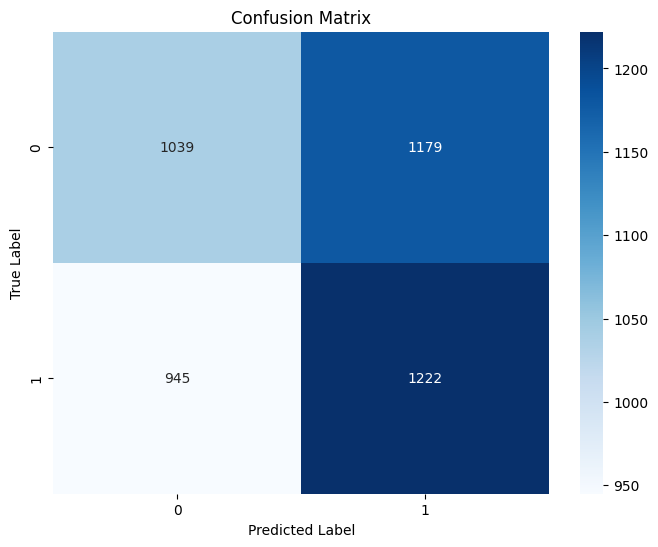


Feature Importance (Coefficient and Odds Ratio):
    Feature  Coefficient  Odds Ratio
1         1         0.05        1.05
3         3         0.04        1.04
18       18         0.03        1.03
12       12         0.02        1.02
19       19         0.01        1.01
5         5         0.01        1.01
11       11         0.01        1.01
9         9         0.00        1.00
4         4        -0.00        1.00
2         2        -0.00        1.00
16       16        -0.01        0.99
8         8        -0.01        0.99
14       14        -0.02        0.98
13       13        -0.02        0.98
10       10        -0.03        0.97
7         7        -0.04        0.96
6         6        -0.07        0.93
17       17        -0.08        0.92
15       15        -0.09        0.91
0         0        -0.11        0.90


In [ ]:
ds_data = adata[:,ds_genes.map(gene_aliases).tolist()]
print(ds_data.obs.disease.value_counts())
# Dieases Specific Genes
X = pd.DataFrame(ds_data.X)
y = ds_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns = X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 ")

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
(17536, 20) (4385, 20) (17536,) (4385,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.504903078677309
F1 
              precision    recall  f1-score   support

           0       0.58      0.07      0.13      2218
           1       0.50      0.95      0.65      2167

    accuracy                           0.50      4385
   macro avg       0.54      0.51      0.39      4385
weighted avg       0.54      0.50      0.39      4385


Confusion Matrix:
[[ 164 2054]
 [ 117 2050]]


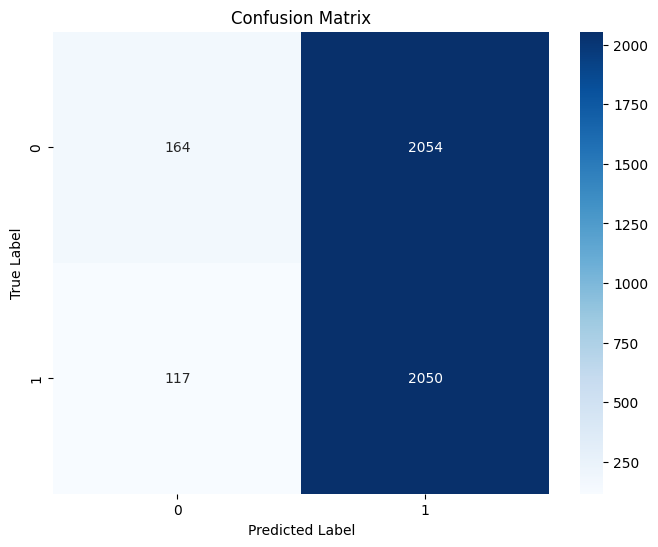


Feature Importance (Coefficient and Odds Ratio):
    Feature  Coefficient  Odds Ratio
3         3         0.03        1.03
15       15         0.03        1.03
11       11         0.02        1.03
10       10         0.02        1.02
1         1         0.02        1.02
13       13         0.01        1.01
7         7         0.01        1.01
5         5         0.00        1.00
18       18         0.00        1.00
14       14        -0.00        1.00
9         9        -0.01        0.99
19       19        -0.01        0.99
12       12        -0.01        0.99
16       16        -0.02        0.98
17       17        -0.02        0.98
6         6        -0.03        0.97
0         0        -0.05        0.95
8         8        -0.06        0.94
4         4        -0.07        0.93
2         2        -0.08        0.92


In [ ]:
ds_data = adata[:,norm_genes.map(gene_aliases).tolist()]
print(ds_data.obs.disease.value_counts())
# Normal Specific Genes
X = pd.DataFrame(ds_data.X)
y = ds_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns = X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 ")

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

(17536, 4477) (4385, 4477) (17536,) (4385,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.7598631698973775
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2218
           1       0.75      0.76      0.76      2167

    accuracy                           0.76      4385
   macro avg       0.76      0.76      0.76      4385
weighted avg       0.76      0.76      0.76      4385


Confusion Matrix:
[[1678  540]
 [ 513 1654]]


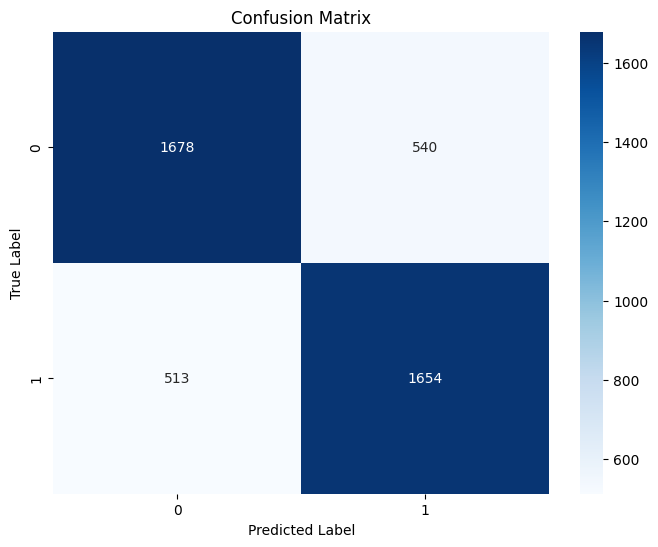


Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
2323          KIF5C-AS1         5.84      343.34
4470             INO80D         3.54       34.38
4221             TTTY14         2.22        9.20
1161               ESF1         1.79        6.00
3435              ROBO1         1.64        5.17
2338               MYL7         1.44        4.24
2324          PDE6B-AS1         1.42        4.13
3625  ENSG00000206028.1         1.40        4.06
3563               NRN1         1.33        3.78
4162              BCL10         1.26        3.53
4045             KCNIP1         1.25        3.50
2685              TRPC3         1.24        3.44
1379                SST         1.22        3.38
1383              SYNPR         1.19        3.29
1235              NCAM2         1.19        3.28
279   ENSG00000280441.3         1.17        3.21
2842          LINC00639         1.16        3.19
939               SMAD7         1.15        3.17
2865               

In [ ]:
# Logistic Regression on All Clusters
X = pd.DataFrame(adata.X)
X.columns = adata.var.feature_name
y = adata.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns = X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False).head(20))

### **Key Observations**
   - The model's performance on the **entire dataset** was more accurate, likely due to the larger amount of data available for training.  
   - In contrast, the model trained on the **disease-specific dataset** exhibited a bias towards predicting the patient as diseased.

## **XGBoost Hyperparam Tuning**
Finally we wanted to see how much Hyperparameter tuning can impact the accuracy of our models. Therefore we used XGBoost and a cross-validated grid search to optimize the parameters.

In [ ]:
search_space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 10e1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1),
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
    'subsample' : hp.uniform("subsample",0.5,1),
    'objective' : 'binary:logistic',
    'eval_metric' : 'aucpr',
    'seed' : 44
}
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical = True)

def xgb_objective(space):
  results = xgb.cv(space,
                   dtrain=dtrain_clf, #DMatrix (xgboost specific)
                   num_boost_round=500,
                   nfold=5,
                   stratified=True,
                   early_stopping_rounds=20,
                   metrics = ['logloss','auc','aucpr','error'])

  best_score = results['test-auc-mean'].max()
  return {'loss':-best_score, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn=xgb_objective, space=search_space,algo=tpe.suggest,max_evals=500,trials=trials, return_argmin=False, early_stop_fn=no_progress_loss(10))

best_params = best_hyperparams.copy()

# `eval_metric` is a key that is not a hyperparameter of the classifier
if 'eval_metric' in best_params:
  best_params = {key:best_params[key] for key in best_params if key!='eval_metric'}

best_params

  3%|▎         | 16/500 [00:20<10:12,  1.27s/trial, best loss: -0.8374086327643517]


{'colsample_bylevel': 0.8845917675792743,
 'colsample_bynode': 0.8566815681938815,
 'colsample_bytree': 0.5509950505000389,
 'eta': 0.17757213716427322,
 'gamma': 0.7604524408062585,
 'max_delta_step': 2,
 'max_depth': 14,
 'min_child_weight': 4,
 'n_estimators': 820,
 'objective': 'binary:logistic',
 'reg_alpha': 3.677738543050372,
 'reg_lambda': 0.3468271561764066,
 'seed': 44,
 'subsample': 0.9745755266273841}

In [ ]:
ds_data = adata[:,ds_genes.map(gene_aliases).tolist()]
print(ds_data.obs.disease.value_counts())
# Dieases Specific Genes
X = pd.DataFrame(ds_data.X)
y = ds_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)


params_1 = {'colsample_bylevel': 0.8845917675792743,
 'colsample_bynode': 0.8566815681938815,
 'colsample_bytree': 0.5509950505000389,
 'eta': 0.17757213716427322,
 'gamma': 0.7604524408062585,
 'max_delta_step': 2,
 'max_depth': 14,
 'min_child_weight': 4,
 'n_estimators': 820,
 'objective': 'binary:logistic',
 'reg_alpha': 3.677738543050372,
 'reg_lambda': 0.3468271561764066,
 'seed': 44,
 'subsample': 0.9745755266273841}
clf_1 = xgb.XGBClassifier(**params_1)
clf_1.fit(X_train,y_train)
pred_1 = clf_1.predict(X_test)


print(f"f1 score : {f1_score(y_test, pred_1)}\n")
print(f"confusion Matrix:\n{confusion_matrix(y_test, pred_1)}\n")


disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
f1 score : 0.7477411477411477

confusion Matrix:
[[1821  397]
 [ 636 1531]]



This was not effective at all. Optimizing the hyperparameters yields exactly the same results.

Maybe its time to move on?

## **Switching to a Different Dataset**

### **Observations**  
As we can see, applying our analysis to the current dataset did not yield significant improvements in accuracy. The results showed no notable increase or decrease in performance.

---

### **Why Switch to a Different Dataset?**

One limitation of our current dataset is the **sample size**:  
- The dataset contains data from only **16 patients** in total, which restricts the diversity and statistical power of the analysis.  
- Limited data may fail to capture the full variability of gene expression, especially in a complex disease like Alzheimer’s.

By applying our gene selection to other datasets, we can:
1. **Increase Statistical Power**:  
   - A larger dataset will provide more robust training data for the model.  
   - It may reveal patterns or markers that were obscured by the small sample size.

2. **Enhance Generalizability**:  
   - Using data from a broader population or from different experimental conditions helps ensure the findings are applicable beyond the original dataset.  
   - This approach reduces the risk of overfitting to the characteristics of the smaller dataset.

3. **Cross-Validate Findings**:  
   - Applying the analysis to an independent dataset allows us to confirm whether the identified markers and patterns are consistent across different patient cohorts or studies.  
   - It strengthens the confidence in our findings.

# **Our Genes in Blood Samples**

### **Initial Dataset Challenges**  
As Francisco pointed out during our previous discussions, the initial dataset was sampled from **brain tissue**, a method that is rarely feasible when the subject is still alive. This limitation highlighted the need for a less intrusive sampling method for ongoing research and diagnostics.

---

### **New Dataset**  
Francisco's team identified a solution by linking **gene expressions** to Alzheimer’s disease (AD) through a much less invasive method: **blood samples**.  

This advancement not only offers a more practical approach to data collection but also opens doors to **early diagnosis** and **broader accessibility** for patients.

---

### **Acknowledgments**  
We extend our gratitude to **Francisco’s team** for their invaluable support in assisting our team with **setup and integration** of the dataset for our analysis.  

<Axes: xlabel='Age', ylabel='count'>

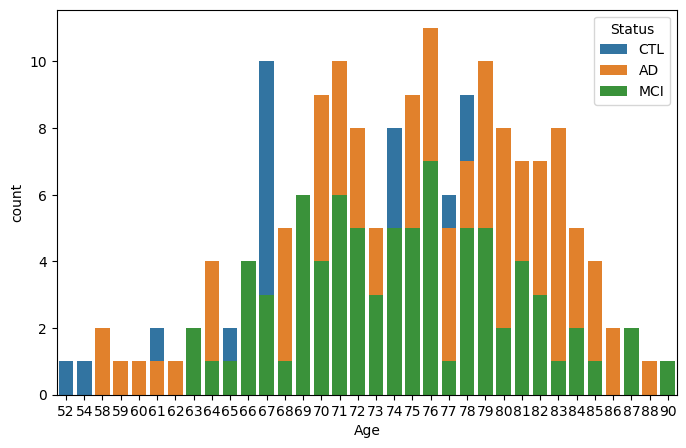

In [ ]:
sns.countplot(x="Age", data=metadata, hue="Status",dodge=False)

## **Initial Observations from the Dataset**

### **1. Status Categories**  
- The dataset includes three separate **Status** categories:  
  1. **Control (CTL)**  
  2. **Alzheimer's Disease (AD)**  
  3. **Mild Cognitive Impairment (MCI)**  

- While these categories are not identical to the **Braak Stages**, we can use **MCI** as a **proxy** for deducing the severity of the disease.

---

### **2. Age Distribution**  
- The dataset is **skewed towards an older population**.  

#### **Advantages**:
- This skew allows us to focus on the age group **most affected by Alzheimer’s disease (AD)**, enhancing the relevance of our findings to the population at **highest risk**.

#### **Limitations**:
- The skew introduces potential limitations:  
  1. **Reduced generalizability** to younger populations.  
  2. **Limited applicability** to earlier stages of **preclinical AD**.


Gender
Female    200
Male      129
Name: count, dtype: int64


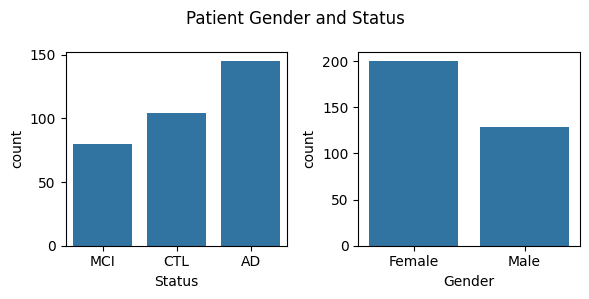

In [ ]:
print(metadata.Gender.value_counts())

fig, axs = plt.subplots(1,2, figsize=(6,3))
fig.suptitle('Patient Gender and Status')

sns.countplot(ax=axs[0],x="Status", data=metadata)
sns.countplot(ax=axs[1],x="Gender", data=metadata)
plt.tight_layout()

The dataset is decently balanced between CTL and AD and Male and Female. The rest of this imbalance should be filtered out by the F1 score of our models.

In [ ]:
norm_genes.tolist()

['SULT1A4',
 'LINC02794',
 'PWP2',
 'ENSG00000261600.1',
 'LRRC26',
 'JMJD7-PLA2G4B',
 'TEKT2',
 'MT1E',
 'MT1G',
 'HCRT',
 'KIF12',
 'LINC01324',
 'ENSG00000273047.1',
 'MYH7',
 'MYL7',
 'TNNI3',
 'LINC02945',
 'ENSG00000236921.1',
 'ENSG00000258938.1',
 'PLXNB1']

In [ ]:
ds_genes.tolist()

['ENSG00000170396',
 'ENSG00000272512',
 'ENSG00000114124',
 'ENSG00000262246',
 'ENSG00000257225',
 'ENSG00000166573',
 'ENSG00000168237',
 'ENSG00000101251',
 'ENSG00000160949',
 'ENSG00000172062',
 'ENSG00000280776',
 'ENSG00000078401',
 'ENSG00000126759',
 'ENSG00000113209',
 'ENSG00000272800',
 'ENSG00000186777',
 'ENSG00000226490',
 'ENSG00000198547',
 'ENSG00000162641',
 'ENSG00000104879']

Lets import and filter the genes that are present in the new dataset:

In [ ]:
### Subset of Blood Sample dataset by Genes of Interest from https://colab.research.google.com/drive/1o066LhjMjxDpF4MUSYJqjdiUXl2Jg2ab?authuser=1#scrollTo=38gHLhKTFTDc

ds_subset = annotations[annotations["ILMN_Gene"].isin(ds_genes.tolist())]
print(ds_subset.shape)

# ds_subset.sort_values(by="ILMN_Gene")
ds_subset.ILMN_Gene.value_counts()
ds_subset

(21, 30)


ILMN_Gene
SMN1       4
TAS1R1     2
CNTNAP5    2
GALR1      2
CSMD1      2
PCDHB5     1
CDCA8      1
GRK7       1
SEL1L2     1
GLYCTK     1
MFGE8      1
CORO7      1
CKM        1
ZNF804A    1
Name: count, dtype: int64

In [ ]:
### Subset of Blood Sample dataset by Genes of Interest from https://colab.research.google.com/drive/1o066LhjMjxDpF4MUSYJqjdiUXl2Jg2ab?authuser=1#scrollTo=38gHLhKTFTDc

norm_subset = annotations[annotations["ILMN_Gene"].isin(norm_genes.tolist())]
print(norm_subset.shape)

# norm_subset.sort_values(by="ILMN_Gene")
norm_subset.ILMN_Gene.value_counts()
norm_subset

(16, 30)


ID                nuID       Species  Source   Search_Key  \
1490   ILMN_1698950  0qUkCKKrUiBJ4DHtHI  Homo sapiens  RefSeq   ILMN_28098   
2193   ILMN_2336130  lWAVAobprdccU.UWzo  Homo sapiens  RefSeq   ILMN_20533   
2194   ILMN_2336133  NCoj0AjXov7qmdXlIo  Homo sapiens  RefSeq   ILMN_20533   
3481   ILMN_1715401  cZeO2oSV51QsQMi4Vs  Homo sapiens  RefSeq   ILMN_22286   
14158  ILMN_1742330  oIvgZd1ylHEB4VdJKk  Homo sapiens  RefSeq   ILMN_22628   
16243  ILMN_1680757  oCfVU5f5XV.Ee3lptA  Homo sapiens  RefSeq   ILMN_41107   
23389  ILMN_2043173  NEsaXRYYr0UnIpBTZ4  Homo sapiens  RefSeq    ILMN_5834   
23598  ILMN_1768637  6hFiCgBaiuoh6aCBNg  Homo sapiens  RefSeq    ILMN_6131   
29737  ILMN_1718968  0bqEQFUHsVXOv0gSJ4  Homo sapiens  RefSeq  ILMN_138005   
32520  ILMN_1681857  00W310Z3_qIJ0OoSFU  Homo sapiens  RefSeq   ILMN_17004   
34571  ILMN_1756705  EigSXiCh9.obuttKJE  Homo sapiens  RefSeq   ILMN_28360   
35536  ILMN_2105960  oh6nUR36n0t5U3ng6I  Homo sapiens  RefSeq   ILMN_22437   
36283  ILMN_2179739  B5XeVFSbSVUgAKQwIY  Homo sapiens  RefSeq   ILMN_25303   
38806  ILMN_1678293  NEehfQBXSpIiSVxHVw  Homo sapiens  RefSeq    ILMN_4761   
40509  ILMN_2173611  cQKpNoguSee5eO6gSc  Homo sapiens  RefSeq    ILMN_2129   
43038  ILMN_1669714  llE343nSV6K5SQJVOc  Homo sapiens  RefSeq    ILMN_4628   

        Transcript ILMN_Gene Source_Reference_ID       RefSeq_ID Unigene_ID  \
1490    ILMN_28098      PWP2         NM_005049.2     NM_005049.2        NaN   
2193    ILMN_20533   SULT1A4      NM_001017391.1  NM_001017391.1        NaN   
2194    ILMN_20533   SULT1A4      NM_001017391.1  NM_001017391.1        NaN   
3481    ILMN_22286      MT1G         NM_005950.1     NM_005950.1        NaN   
14158   ILMN_22628    PLXNB1         NM_002673.3     NM_002673.3        NaN   
16243  ILMN_182870    LRRC26      NM_001013653.2  NM_001013653.2        NaN   
23389    ILMN_5834     TEKT2         NM_014466.2     NM_014466.2        NaN   
23598    ILMN_6131     TNNI3         NM_000363.3     NM_000363.3        NaN   
29737  ILMN_138005      MT1E         NM_175617.2     NM_175617.2        NaN   
32520   ILMN_17004      MYL7         NM_021223.2     NM_021223.2        NaN   
34571   ILMN_28360    CHTF18         NM_022092.1     NM_022092.1        NaN   
35536   ILMN_22437     KIF12         NM_138424.1     NM_138424.1        NaN   
36283   ILMN_25303      HCRT         NM_001524.1     NM_001524.1        NaN   
38806   ILMN_20198   SULT1A4      NM_001017390.1  NM_001017390.1        NaN   
40509    ILMN_2129      MT1E         NM_175617.3     NM_175617.3        NaN   
43038  ILMN_180846      MYH7         NM_000257.2     NM_000257.2        NaN   

       ...  Probe_Chr_Orientation                    Probe_Coordinates  \
1490   ...                      +                    30921003-30921052   
2193   ...                      +                    29382181-29382230   
2194   ...                      +                    29382990-29383039   
3481   ...                      -  42570202-42570246:42570247-42570251   
14158  ...                      -                    48420387-48420436   
16243  ...                      -                  109523246-109523295   
23389  ...                      +                    34670474-34670523   
23598  ...                      -  60355059-60355097:60357210-60357220   
29737  ...                      +                    55218122-55218171   
32520  ...                      -  44218947-44218958:44219421-44219458   
34571  ...                      +          787085-787093:787695-787735   
35536  ...                      -                    86460377-86460426   
36283  ...                      -                    37589613-37589662   
38806  ...                      +                    29378695-29378744   
40509  ...                      +  42530305-42530341:42530342-42530354   
43038  ...                      -                      3998447-3998496   

              Cytoband                                         Definition  \
1490      

In [ ]:
# Create Lookup table to Map to Df columns
gene_index = pd.Series(annotations.ILMN_Gene.values,index=annotations.ID).to_dict()
gene_index["Status"] = "Status"
gene_index["Age"] = "Age"
gene_index["Gender"] = "Gender"

#**ML Analysis 2**

In [ ]:
# Format Data
def preprocess_data(df):
  X = df.drop(columns=['Status', 'Age', 'Gender'])
  y = df['Status'].astype("category").cat.codes

  X_norm = preprocessing.Normalizer().fit_transform(X)
  X_scaled = StandardScaler().fit_transform(X_norm)

  X = pd.DataFrame(X_scaled, columns = X.columns)
  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1337)
  return X, y, X_train, X_test, y_train, y_test

# Make column names unique using a loop
def unique_columns(df):
  new_columns = []
  for col in df.columns:
      i = 1
      new_col = col
      while new_col in new_columns:
          new_col = f"{col}_{i}"
          i += 1
      new_columns.append(new_col)

  df.columns = new_columns
  return df

For this round we will use similar but not identical subsets.

1. Disease specifc clusters: Same as in ML analysis 1 (top expressed genes in DS clusters)

2. Normal specific clusters: Same as in ML analysis 1 (top expressed genes in norm clusters)
3. Combined: 1. and 2. combined

4. Random Genes: A random selection of genes

5. Disease specific no clustering: top expressed genes for AD subjects grouped by disease without subsampling by clustering

6. Normal specific no clustering: top expressed genes for normal subjects grouped by disease without subsampling by clustering

In [ ]:
# Map Index and create dfs
df = dataset.copy()
df.columns = df.columns.map(gene_index)
df = df.loc[:,df.columns.notna()]
df.Status = df.Status.apply(lambda x: x.replace("MCI", "AD"))

# Disease Specific
ds_df = df.copy()
ds_df = ds_df.loc[:,ds_df.columns.isin(ds_genes.tolist()+['Status','Age','Gender'])]

# Normnal Specific
norm_df = df.copy()
norm_df = norm_df.loc[:,norm_df.columns.isin(norm_genes.tolist()+['Status','Age','Gender'])]

# Combined
both_df = df.copy()
both_df = both_df.loc[:,both_df.columns.isin(ds_genes.tolist()+norm_genes.tolist()+['Status','Age','Gender'])]

#Random
rand_df = df.copy()
rand_df = rand_df.loc[:,rand_df.columns.isin(np.random.choice(rand_df.columns,size=5,replace=False).tolist()+['Status','Age','Gender'])]

#Dr. Fangs Approach
nc_ad_df = df.copy()
nc_ad_df = nc_ad_df.loc[:,nc_ad_df.columns.isin(nc_ds_genes.tolist() +['Status','Age','Gender'])]
#Dr. Fangs Approach
nc_norm_df = df.copy()
nc_norm_df = nc_norm_df.loc[:,nc_norm_df.columns.isin(nc_norm_genes.tolist() +['Status','Age','Gender'])]

print(f"DF: {df.shape}")
print(df.Status.value_counts())
print(f"DS_DF: {ds_df.shape}")
print(f"Norm_DF: {norm_df.shape}")
print(f"Both_DF: {both_df.shape}")
print(f"Rand_DF: {rand_df.shape}")
print(f"NC_AD_DF: {nc_ad_df.shape}")
print(f"NC_Norm_DF: {nc_norm_df.shape}")

#Fix Columns
experiments = {'df':df,'ds_df':ds_df, 'norm_df':norm_df, 'both_df':both_df,'rand_df':rand_df,'nc_ad_df':nc_ad_df,'nc_norm_df':nc_norm_df}
for experiment in experiments:
  experiments[experiment] = unique_columns(experiments[experiment])

DF: (329, 38326)
Status
AD     225
CTL    104
Name: count, dtype: int64
DS_DF: (329, 19)
Norm_DF: (329, 17)
Both_DF: (329, 33)
Rand_DF: (329, 11)
NC_AD_DF: (329, 9)
NC_Norm_DF: (329, 12)


## **Model Analysis**

To analyze the performance

In [ ]:
### Run model Analysis
%%capture
model_dict = {}

for experiment in experiments:
  X,y,X_train, X_test, y_train, y_test = preprocess_data(experiments[experiment])
  clf = LazyClassifier(predictions=True,verbose=0)
  models, predictions = clf.fit(X_train, X_test, y_train, y_test)
  models["experiment"] = experiment
  model_dict[experiment] = models



In [ ]:
model_ranking = pd.concat([model_dict["df"],model_dict["ds_df"],model_dict["norm_df"],model_dict["both_df"],model_dict["rand_df"],model_dict['nc_ad_df'],model_dict['nc_norm_df']])
model_ranking.groupby("experiment")["F1 Score"].nlargest(5)

experiment  Model                        
both_df     XGBClassifier                   0.79
            LGBMClassifier                  0.75
            GaussianNB                      0.74
            BernoulliNB                     0.74
            RandomForestClassifier          0.72
df          NearestCentroid                 0.82
            BernoulliNB                     0.80
            LGBMClassifier                  0.79
            GaussianNB                      0.79
            XGBClassifier                   0.77
ds_df       GaussianNB                      0.79
            Perceptron                      0.76
            BernoulliNB                     0.76
            SGDClassifier                   0.75
            NearestCentroid                 0.72
nc_ad_df    BernoulliNB                     0.63
            NearestCentroid                 0.62
            LabelSpreading                  0.58
            XGBClassifier                   0.57
            LabelPropagation                0.57
nc_norm_df  BernoulliNB                     0.66
            NearestCentroid                 0.66
            SGDClassifier                   0.65
            KNeighborsClassifier            0.65
            PassiveAggressiveClassifier     0.64
norm_df     LinearDiscriminantAnalysis      0.75
            LogisticRegression              0.73
            RidgeClassifierCV               0.71
            LinearSVC                       0.71
            RidgeClassifier                 0.70
rand_df     QuadraticDiscriminantAnalysis   0.63
            XGBClassifier                   0.61
            BaggingClassifier               0.60
            AdaBoostClassifier              0.58
            RandomForestClassifier          0.56
Name: F1 Score, dtype: float64

## **Top 5 Model Performances for the New Dataset**

### **Key Observations from the Table**:

1. **Overall Predictive Power**:  
   - Using all features, predictive power is slightly **lower than the previous dataset**, with accuracy dropping from **85%** to **82%**.

2. **Disease-Specific Subset (ds_df)**:  
   - The **ds_df subset**, which includes the **20 genes identified by the disease-specific clusters**, achieved an **F1 score of 0.79**, only marginally worse than using all features (**0.82**).  
   - This indicates that these **20 genes** explain a significant amount of variance in the data and are **decent predictors for AD**.

3. **Normal Subset Performance**:  
   - The **normal subset** performed worse, with an **F1 score of 0.75**, suggesting it is less effective in predicting AD.

4. **Combining Subsets**:  
   - Combining the subsets (**DS and Norm = Both**) did **not improve accuracy or F1 scores** further (**0.79**). This indicates that extending the gene sets does not yield a significant improvment

5. **Sanity Check**:  
   - As a control, we ran the same models using a subset of **randomly selected genes** (**0.63**).  
   - The results confirm that the genes identified by our method capture significantly more variance, offering **higher predictive power** than random selection.

6. **Gene Expression without clustering**
- As a second control we also ran the same models using a subset of genes  directly from the gene expression analysis bypassing cell clustering.
- These performed very similarly to the random subset, further validating our methodology.

## **Baseline Logistic Regression**

(263, 38323) (66, 38323) (263,) (66,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.7575757575757576
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        41
           1       0.85      0.44      0.58        25

    accuracy                           0.76        66
   macro avg       0.79      0.70      0.70        66
weighted avg       0.78      0.76      0.73        66


Confusion Matrix:
[[39  2]
 [14 11]]


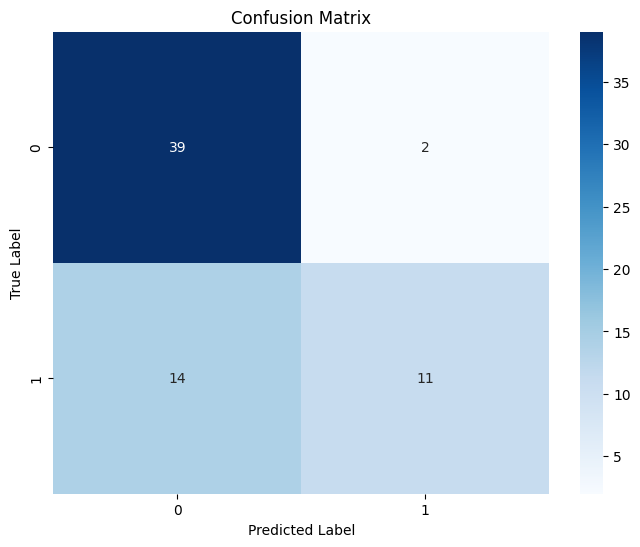


Feature Importance (Coefficient and Odds Ratio):
         Feature  Coefficient  Odds Ratio
35806     BMP1_5         0.01        1.01
7475       CETN2         0.01        1.01
2019      METTL6         0.01        1.01
9527    ADRA1A_1         0.01        1.01
2300   LOC729569         0.01        1.01
...          ...          ...         ...
28323  HS.565836        -0.01        0.99
10502       FRZB        -0.01        0.99
6821   LOC644768        -0.01        0.99
3402      MCF2L2        -0.01        0.99
21042      LRRC3        -0.01        0.99

[38323 rows x 3 columns]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression on All

X,y,X_train, X_test, y_train, y_test = preprocess_data(df)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

## **DS Logistic Regression**

(263, 16) (66, 16) (263,) (66,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.6212121212121212
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        41
           1       0.50      0.16      0.24        25

    accuracy                           0.62        66
   macro avg       0.57      0.53      0.49        66
weighted avg       0.59      0.62      0.56        66


Confusion Matrix:
[[37  4]
 [21  4]]


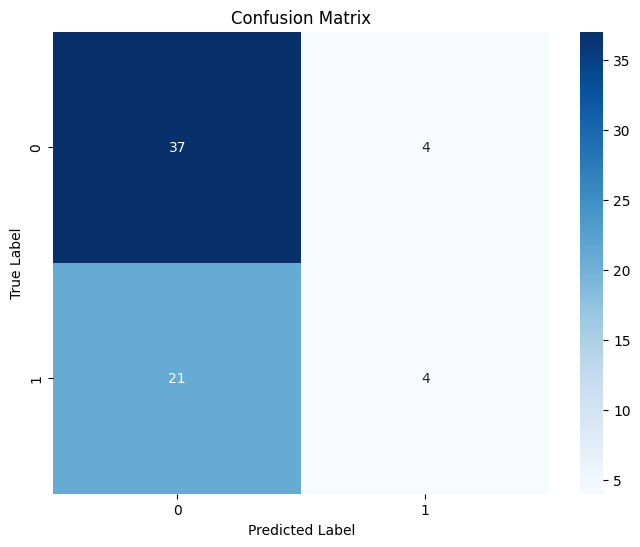


Feature Importance (Coefficient and Odds Ratio):
      Feature  Coefficient  Odds Ratio
2      SMN1_1         0.30        1.35
3       CDCA8         0.24        1.28
0     ZNF804A         0.23        1.26
15  CNTNAP5_1         0.21        1.23
7         CKM         0.13        1.14
6       MFGE8         0.12        1.13
9        GRK7         0.11        1.12
4     CNTNAP5         0.07        1.08
14     SMN1_2         0.06        1.07
13    CSMD1_1        -0.01        0.99
1        SMN1        -0.04        0.96
8       GALR1        -0.05        0.95
10     GLYCTK        -0.05        0.95
5       CSMD1        -0.13        0.88
11      CORO7        -0.43        0.65
12    GALR1_1        -0.53        0.59


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression on Disease Specific Clusters

X,y,X_train, X_test, y_train, y_test = preprocess_data(ds_df)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

## **Norm Logistic Regression**

(263, 14) (66, 14) (263,) (66,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.7424242424242424
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        41
           1       0.75      0.48      0.59        25

    accuracy                           0.74        66
   macro avg       0.74      0.69      0.70        66
weighted avg       0.74      0.74      0.73        66


Confusion Matrix:
[[37  4]
 [13 12]]


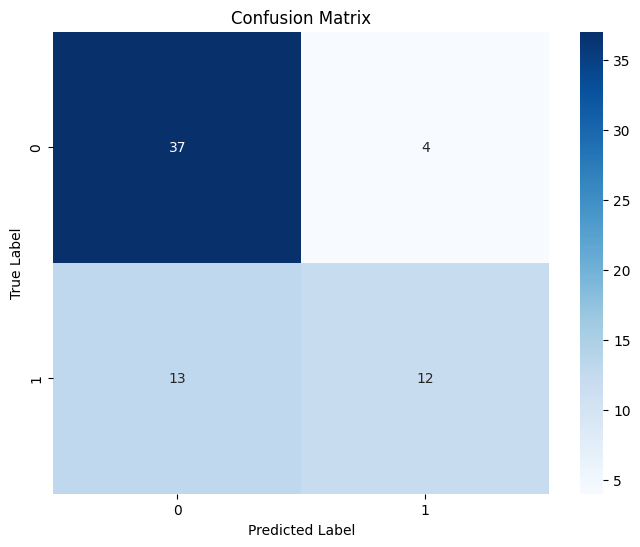


Feature Importance (Coefficient and Odds Ratio):
      Feature  Coefficient  Odds Ratio
0        MYH7         0.36        1.43
10       MT1E         0.33        1.39
3        MYL7         0.31        1.36
8       TNNI3         0.25        1.29
5        MT1G         0.25        1.28
2      LRRC26         0.20        1.22
11       HCRT         0.18        1.19
4        PWP2         0.16        1.17
13  SULT1A4_2         0.15        1.17
1     SULT1A4         0.01        1.01
7      CHTF18        -0.00        1.00
6      PLXNB1        -0.08        0.92
12  SULT1A4_1        -0.36        0.70
9       TEKT2        -0.47        0.62


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression on Normal Specific Cluster groups

X,y,X_train, X_test, y_train, y_test = preprocess_data(norm_df)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

## **Both Logistic Regression**

(263, 30) (66, 30) (263,) (66,)

Model Evaluation:
ACCURACY OF THE MODEL: 0.696969696969697
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        41
           1       0.63      0.48      0.55        25

    accuracy                           0.70        66
   macro avg       0.68      0.65      0.66        66
weighted avg       0.69      0.70      0.69        66


Confusion Matrix:
[[34  7]
 [13 12]]


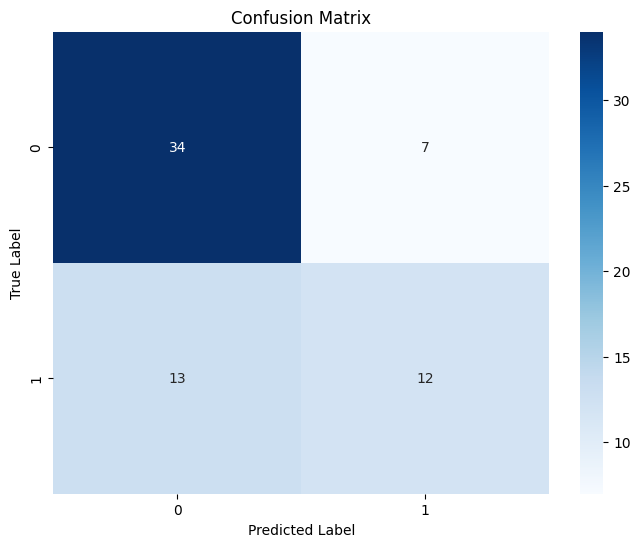


Feature Importance (Coefficient and Odds Ratio):
      Feature  Coefficient  Odds Ratio
29  CNTNAP5_1         0.44        1.55
13      MFGE8         0.42        1.52
2        MYH7         0.35        1.42
0     ZNF804A         0.32        1.38
6        MYL7         0.31        1.37
10       MT1G         0.30        1.35
3      SMN1_1         0.29        1.34
18      TNNI3         0.27        1.31
8       CDCA8         0.26        1.30
27  SULT1A4_2         0.21        1.23
9     CNTNAP5         0.16        1.18
7        PWP2         0.16        1.17
19     GLYCTK         0.16        1.17
23       MT1E         0.15        1.16
5      LRRC26         0.14        1.15
24       HCRT         0.08        1.09
15        CKM         0.07        1.08
17       GRK7         0.05        1.05
16      GALR1         0.01        1.01
12      CSMD1        -0.02        0.98
14     CHTF18        -0.03        0.97
28     SMN1_2        -0.04        0.96
4     SULT1A4        -0.04        0.96
25    CSMD1_1 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression on Both Cluster groups

X,y,X_train, X_test, y_train, y_test = preprocess_data(both_df)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("\nModel Evaluation:")
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coefficients = lr_model.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

##**PCA**

What we also wanted to explore is the concept of explained variance via a PCA. In essence what we want to see is a so called elbow curve. An elbow curve would indicate that a specific subset of genes explain more variance than others. For example in the image below we can see a slight elbow at n>5 n<10.

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

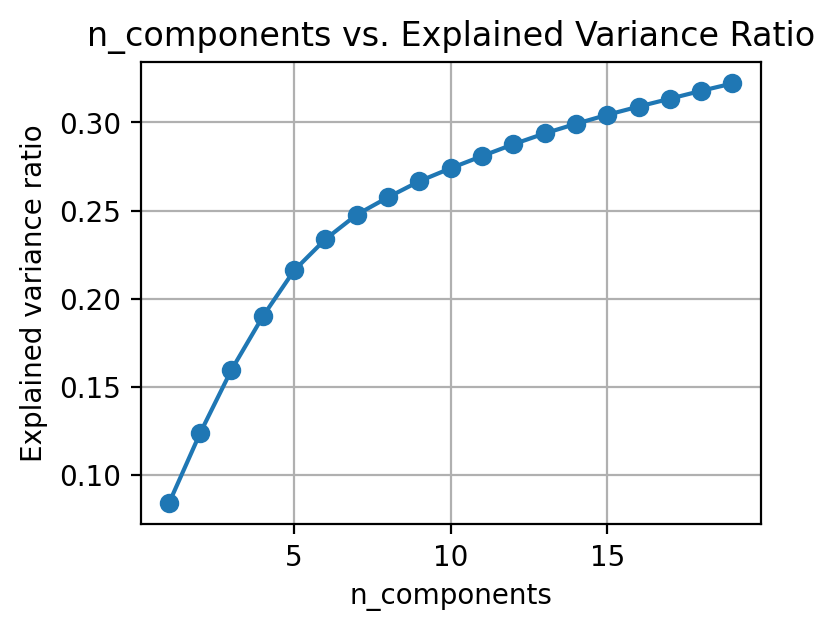

In [ ]:
from sklearn.decomposition import PCA
X,y,_,_,_,_ = preprocess_data(df)
nums = np.arange(1, 20)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,3),dpi=200)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
#This broke overnight and takes hours to run.

from sklearn.decomposition import PCA

X,y,_,_,_,_ = preprocess_data(df)
nums = np.arange(1, 300)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

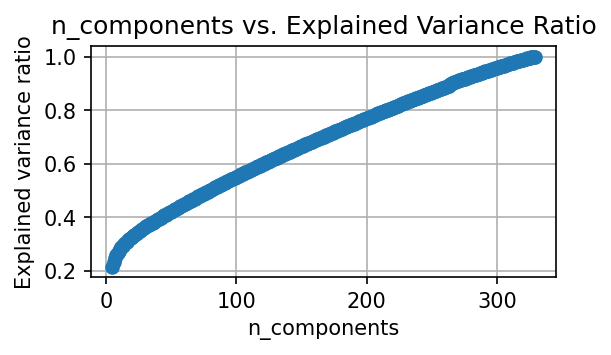


Unfortunatly this is not really what we see. As we increase the number of features as part of the PCA the explained variance rises more or less linearly. This means that there are no specific genes that explain most of the variance. Therefore our approach has reached the ceiling.

##**GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

X,y,X_train, X_test, y_train, y_test = preprocess_data(ds_df)


clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("ACCURACY OF THE MODEL:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 SCORE OF THE MODEL:", sklearn.metrics.f1_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


ACCURACY OF THE MODEL: 0.7878787878787878
F1 SCORE OF THE MODEL: 0.7083333333333334
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        41
           1       0.74      0.68      0.71        25

    accuracy                           0.79        66
   macro avg       0.78      0.77      0.77        66
weighted avg       0.79      0.79      0.79        66



## **XGBoost**

As a final step we ran a similar XGboost optimization routine as in the first ML analysis which yielded similar results.

In [ ]:
search_space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 10e1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1),
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
    'subsample' : hp.uniform("subsample",0.5,1),
    'objective' : 'binary:logistic',
    'eval_metric' : 'aucpr',
    'seed' : 44
}
X,y,X_train, X_test, y_train, y_test = preprocess_data(ds_df)
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical = True)

def xgb_objective(space):
  results = xgb.cv(space,
                   dtrain=dtrain_clf, #DMatrix (xgboost specific)
                   num_boost_round=500,
                   nfold=5,
                   stratified=True,
                   early_stopping_rounds=20,
                   metrics = ['logloss','auc','aucpr','error'])

  best_score = results['test-auc-mean'].max()
  return {'loss':-best_score, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn=xgb_objective, space=search_space,algo=tpe.suggest,max_evals=500,trials=trials, return_argmin=False, early_stop_fn=no_progress_loss(10))

best_params = best_hyperparams.copy()

# `eval_metric` is a key that is not a hyperparameter of the classifier
if 'eval_metric' in best_params:
  best_params = {key:best_params[key] for key in best_params if key!='eval_metric'}

best_params

  3%|▎         | 15/500 [00:01<00:34, 13.87trial/s, best loss: -0.6397484984984985]


{'colsample_bylevel': 0.8723519655917193,
 'colsample_bynode': 0.5179181552670908,
 'colsample_bytree': 0.8374046834404081,
 'eta': 0.20988747625643878,
 'gamma': 8.278293980913931,
 'max_delta_step': 6,
 'max_depth': 19,
 'min_child_weight': 5,
 'n_estimators': 600,
 'objective': 'binary:logistic',
 'reg_alpha': 5.617545262654607,
 'reg_lambda': 0.19056161188546505,
 'seed': 44,
 'subsample': 0.9221722813346273}

In [117]:
ds_data = adata[:,ds_genes.map(gene_aliases).tolist()]
print(ds_data.obs.disease.value_counts())
# Dieases Specific Genes
X = pd.DataFrame(ds_data.X)
y = ds_data.obs['disease'].cat.codes

scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=12)

params_1 = {'colsample_bylevel': 0.8723519655917193,
 'colsample_bynode': 0.5179181552670908,
 'colsample_bytree': 0.8374046834404081,
 'eta': 0.20988747625643878,
 'gamma': 8.278293980913931,
 'max_delta_step': 6,
 'max_depth': 19,
 'min_child_weight': 5,
 'n_estimators': 600,
 'objective': 'binary:logistic',
 'reg_alpha': 5.617545262654607,
 'reg_lambda': 0.19056161188546505,
 'seed': 44,
 'subsample': 0.9221722813346273}
clf_1 = xgb.XGBClassifier(**params_1)
clf_1.fit(X_train,y_train)
pred_1 = clf_1.predict(X_test)


print(f"f1 score : {f1_score(y_test, pred_1)}\n")
#print(f"accuracy : {accuracy(y_test, pred_1)}\n")

print(f"confusion Matrix:\n{confusion_matrix(y_test, pred_1)}\n")


disease
normal               11077
Alzheimer disease    10844
Name: count, dtype: int64
f1 score : 0.7219979818365287

confusion Matrix:
[[1852  366]
 [ 736 1431]]



## **Limitations**

### **1. Data Size and Availability**  
- Both datasets used in this study had a **limited number of participants**:  
  - The **CellxGene dataset** provided extensive data for each individual participant but included only **8 AD** and **8 CTL subjects**.  
  - The **blood dataset** had a larger sample size (**329 participants**), but this was still insufficient for training larger, more complex models like neural networks.  With only **329 observations**, it is not feasible to train a neural network to predict with the **precision and reliability** needed.

---

### **2. Timeline Constraints**  
- Despite significant investment of time, **progress was challenging**.  
- The team explored several avenues that initially seemed promising but ultimately resulted in **insignificant findings**. While these efforts advanced understanding, they did not yield **presentation-ready results**.  
- **More time** would have allowed for incorporating additional datasets and further expanding the research scope.

---

### **3. Lack of Domain Expertise**  
- While the team excelled in data science, there was a **lack of specific domain expertise** in:  
  - **RNA gene sequencing analysis**  
  - **Biological implications** of the identified genes  
- This gap often required the team to **research the biological role of genes** and their potential causal relationships, which was **time-consuming and non-linear**.  
- Progress was slower than expected, as no team member had **expert-level knowledge** in these critical areas.


# **Conclusion**


In conclusion our analysis was successful but not clinically relevant.
We were able to indenfity clusters of particular interest that exhibited characteristics across two dataset which validates our hypothesis that disticnt gene markers can help predict AD within subjects.

Despite several atempts the team was only able to create models with an accuracy and F1 scores around 0.75 which translates to 3/4 success rate. Around 10% lower than simply training machine learning algorithms on the full dataset.

While we were able to reduce the dimensions of the dataset by 99% and the runtime of several algorithms by a factor 10 the implicaions for this are rather sleek. Even in the worst case scenario this only added a couple of hours to total runtime. While this was an obstacle for our fast moving ivestigation it does not make sense in long running research project.  

What supplements our findings is that our random selection of genes performed worse than the genes selected based on gene expression differences.
As can be seen in the table under Model Analysis we were able to achieve an F1 score of 0.79 with our gene selection and the random selection was only able to achieve an F1 score of 0.68. This strongly support our hypothesis.  

While this is in theory statistically significant it does not meet the bar for clinical relevance in our opinion.

As such we have proven the hypothesis to be correct but futher research needs to conducted to investigate the specificities uncovered:

- **converting MCI to AD:** This had to be done in order to achieve a reasonable predictive power.
- **Exploring Additional Datasets**: Expanding the research with larger, more diverse datasets could enhance predictive accuracy and **clinical applicability**.

- **Linking our finings back to Age/Gender/Race/etc:** Due to time constraints our team was not able to go back and correlate our findings with the metadata offered by the cellxgene dataset.






#*Innovation*


Several parts of our research were novel and innovative:

1. Hyper granular clustering and interpretation
 Our research went beyond the cell clusters, segmenting the data into smaller subcluster. These smaller subclusters identified disease-specific and normal-specific clusters that provided insight into he heterogenity of the AD pathology

2. Integration of Single-soma transcriptomics with blood samples
  Our research was (together with Franciscos team) the first to attempt to apply insights gained from single-soma analysis to a more common and approachable dataset. This integration helps to extrapolate findings from invasive brain-tissue studies to non-invasive blood samples which is critical for practcal and scalable diagnostics

3. Heavy emphasis on Machine learning. Our team excelled in data science domain knowledge, so many of our procedures and methods were inspired by this approach.
